In [2]:
%matplotlib inline

import os
import sys
import shutil
import pandas
import numpy
import ipystata
import matplotlib.pyplot as plt

from ipystata.config import config_stata
config_stata('/home/kmongeon/research/stata14/stata-mp',force_batch=True)

from ipystata.config import config_syntax_higlight    
config_syntax_higlight(True)  

pandas.options.display.max_columns = 100


In [3]:
pwd

'/home/kmongeon/research/exercise_physiology/scripts'

In [4]:
try: 
    shutil.rmtree('out')
    os.mkdir('out')
except:
    pass

In [5]:
%%stata --output dm

import delimited ./data/IzzyLongitudinalWorkingMarch2015.csv,  case(lower) clear 
order id session sequence
sort id sequence
save ./out/di, replace

import delimited ./data/torque.csv, case(lower) clear
drop if session==0
drop sequence
rename new_sequence sequence
order id session sequence
sort id  sequence
foreach var in ptiso pt60 pt240 {
replace `var' = . if `var'==-9999
}
save ./out/dt, replace

** Identify potentially data with errors
* Nota: July  2016
import delimited ./data/NegativeIDs.csv, case(lower) clear
keep nota id sequence 
keep if nota==1
save ./out/db1, replace

* Baraket: Nov 2016
import delimited ./data/data_examine_falk_nov2016.csv, case(lower) clear
keep falk id sequence
keep if falk==1
save ./out/db2, replace

* merge
use ./out/di, clear
sort id sequence
merge 1:1 id sequence using ./out/dt,  nogen
merge 1:1 id sequence using ./out/db1, nogen
merge 1:1 id sequence using ./out/db2, nogen

    
rename radius_sos rsos
rename tibial_sos tsos

rename grip_strength_best grip 
rename mat_offset_new matu

rename godin_pa godin
rename ntxcreat ntxc
rename caloricintake cint
renam calcium calc 
rename vitd vitd 
rename v48 vitd2
rename paq_total_score paq
rename totmvh mvh

rename forearm_length flength
rename thigh_length   tlength

global U id session sequence 
global Y rsos tsos
global X grip ptiso pt60 godin paq ntxc cint calc vitd vitd2 mvh
global Z matu age gender
global D nota falk

*keep $U $Y $X $Z $D

***grip only

*drop if missing(rsos)
*drop if missing(tsos)
*drop if missing(grip)
*drop if missing(ptiso) 
drop if matu>5
drop if id==517 & sequence==7

sort id sequence
by id: egen seq = seq()
global U id session sequence seq

order $U $D $Y $X $Z 
sum *
xtset id seq
count 

capture drop griph 
reg grip rsos 
predict griph 
replace griph = grip if (!missing(grip) & nota!=1)

reg ptiso matu

capture drop ptisoh  
*replace ptiso =. if ptiso>250
reg ptiso tsos
predict ptisoh 
replace ptisoh = ptiso if !missing(ptiso) 

capture drop ptisoh2  
reg ptisoh matu
predict ptisoh2 
replace ptisoh = ptisoh2 if missing(ptisoh) 
drop ptisoh2

capture drop rsosh  
reg rsos griph  
predict rsosh 
replace rsosh = rsos if (!missing(rsos) & nota!=1)

capture drop tsosh  
reg tsos ptisoh  
predict tsosh 
replace tsosh = tsos if (falk!=1 & !missing(tsos))

capture drop flengthh  
reg flength rsosh
predict flengthh 
replace flengthh = flength if !missing(flength)

capture drop tlengthh  
reg tlength tsosh
predict tlengthh 
replace tlengthh = tlength if !missing(tlength)


capture drop mvhh  
reg mvh ptisoh 
predict mvhh 
replace mvhh = mvh if !missing(mvh)

capture drop sedh  
reg totsedetary ptisoh 
predict sedh 
replace sedh = totsedetary if !missing(mvh)

capture drop ntxch  
reg ntxc rsosh 
predict ntxh 
replace ntxh = ntxc if !missing(ntxc)

capture drop godinh  
reg godin tsosh
predict godinh 
replace godinh = godin if !missing(godin)

capture drop paqh  
reg paq matu 
predict paqh 
replace paqh = paq if !missing(paq)

capture drop paqprvnth  
reg paqprvnt matu 
predict paqprvnth 
replace paqprvnth = paqprvnt if !missing(paqprvnt)

capture drop calch  
reg calc matu
predict calch 
replace calch = calc if !missing(calc)

capture drop cinth  
reg cint matu
predict cinth 
replace cinth = cint if !missing(cint)

capture drop vitdh  
reg vitd matu
predict vitdh 
replace vitdh = vitd if !missing(vitd)

sort id seq
by id: egen trips = max(seq)
order trips, after(seq)

gen boy = 1 if gender==0
gen girl = 1 if gender==1




(70 vars, 427 obs)
(note: file ./out/di.dta not found)
file ./out/di.dta saved
(14 vars, 421 obs)
(40 observations deleted)(65 real changes made, 65 to missing)
(65 real changes made, 65 to missing)
(65 real changes made, 65 to missing)
(note: file ./out/dt.dta not found)
file ./out/dt.dta saved
. * Nota: July  2016(32 vars, 109 obs)
(59 observations deleted)
(note: file ./out/db1.dta not found)
file ./out/db1.dta saved
. import delimited ./data/data_examine_falk_nov2016.csv, case(lower) clear
(34 vars, 473 obs)
(460 observations deleted)
(note: file ./out/db2.dta not found)
file ./out/db2.dta saved
. use ./out/di, clear

    Result                           # of obs.
    -----------------------------------------
    not matched                            58
        from master                        52  
        from using                          6  

    matched                               375  
    -----------------------------------------

    Result                           #

In [6]:
dm['rsoshs'] = (dm['rsosh'] - dm['rsosh'].mean()) / dm['rsosh'].std()
dm['tsoshs'] = (dm['tsosh'] - dm['tsosh'].mean()) / dm['tsosh'].std()
dm['griphs'] = (dm['griph'] - dm['griph'].mean()) / dm['griph'].std()
dm['ptisohs'] = (dm['ptisoh'] - dm['ptisoh'].mean()) / dm['ptisoh'].std()
dm['ntxhs'] = (dm['ntxh'] - dm['ntxh'].mean()) / dm['ntxh'].std()

dm['mvhhs'] = (dm['mvhh'] - dm['mvhh'].mean()) / dm['mvhh'].std()
dm['sedhs'] = (dm['sedh'] - dm['sedh'].mean()) / dm['sedh'].std()

dm['godhs'] = (dm['godinh'] - dm['godinh'].mean()) / dm['godinh'].std()
dm['paqhs'] = (dm['paqh'] - dm['paqh'].mean()) / dm['paqh'].std()

dm['cinths'] = (dm['cinth'] - dm['cinth'].mean()) / dm['cinth'].std()
dm['vitdhs'] = (dm['vitdh'] - dm['vitdh'].mean()) / dm['vitdh'].std()
dm['calchs'] = (dm['calch'] - dm['calch'].mean()) / dm['calch'].std()

dm['flengthhs'] = (dm['flengthh'] - dm['flengthh'].mean()) / dm['flengthh'].std()
dm['tlengthhs'] = (dm['tlengthh'] - dm['tlengthh'].mean()) / dm['tlengthh'].std()

dm['heights'] = (dm['height'] - dm['height'].mean()) / dm['height'].std()
dm['weights'] = (dm['weight'] - dm['weight'].mean()) / dm['weight'].std()

dm['matus'] = (dm['matu'] - dm['matu'].mean()) / dm['matu'].std()
dm['bages'] = (dm['bone_age'] - dm['bone_age'].mean()) / dm['bone_age'].std()

dm['matu2']  = dm['matu']**2
dm['matu3']  = dm['matu']**3
dm['matu4']  = dm['matu']**4

dm['ntxhs_g'] = dm['ntxhs']
dm['ntxhs_t'] = dm['ntxhs']
dm['torqhs'] = dm['ptisohs']
dm['paqp'] = dm['paqprvnth']
dm['paqps'] = (dm['paqp'] - dm['paqp'].mean()) / dm['paqp'].std()
dm['bmis'] = (dm['bmi'] - dm['bmi'].mean()) / dm['bmi'].std()
dm['lbmkgs'] = (dm['lbmkg'] - dm['lbmkg'].mean()) / dm['lbmkg'].std()


dm['griphs_boy'] = dm['griphs']*dm['boy']
dm['griphs_gir'] = dm['griphs']*dm['girl']
dm['rsoshs_boy'] = dm['rsoshs']*dm['boy']
dm['rsoshs_gir'] = dm['rsoshs']*dm['girl']
dm.head(2)

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,ptiso,pt60,godin,paq,ntxc,cint,calc,vitd,vitd2,mvh,matu,age,gender,height,seatedheight,leglength,weight,bf_slaughter,bia_pbf,bmi,lbmkg,yearsfromaphv,age_at_phv,bone_age,tanner,menarche,age_first_period,period_frequency,medications,vitamins,fracture,radius_z,tibial_z,wrist_flexion_best,flength,forearm_lean_csa,forearm_us_csa,anterior_csa,anteriorradius,ant_rad_csa,...,pt240,griph,ptisoh,rsosh,tsosh,flengthh,tlengthh,mvhh,sedh,ntxh,godinh,paqh,paqprvnth,calch,cinth,vitdh,boy,girl,rsoshs,tsoshs,griphs,ptisohs,ntxhs,mvhhs,sedhs,godhs,paqhs,cinths,vitdhs,calchs,flengthhs,tlengthhs,heights,weights,matus,bages,matu2,matu3,matu4,ntxhs_g,ntxhs_t,torqhs,paqp,paqps,bmis,lbmkgs,griphs_boy,griphs_gir,rsoshs_boy,rsoshs_gir
0,100,1,1,1,4.0,NaN,NaN,3828.0,3601.0,NaN,113.928055,69.291710,37.0,2.5866,711.848145,1572.000000,1077.668945,3.382,135.274002,105.709999,-1.67,11.75,0,152.000000,75.199997,76.800003,44.200001,22.809999,21.9,19.129999,34.119999,-2.13,13.88,11.16,2.0,NaN,,,0.0,0.0,0,0.8,-0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.800179,23.770721,113.928055,3828.0,3601.0,23.766197,35.5,105.709999,78.430000,711.848145,37.0,2.5866,1.0,1077.668945,1572.000000,3.382,1.0,NaN,0.106119,-0.813017,0.063802,-0.254023,0.681627,0.056194,0.828167,-0.900483,-0.842358,-0.054358,-0.421275,0.222979,0.03652,0.216919,-0.024812,-0.171335,-0.399805,-0.380438,2.7889,-4.657463,7.777962,0.681627,0.681627,-0.254023,1.0,3.056136,-0.159839,-0.266719,0.063802,NaN,0.106119,NaN
1,100,1,3,2,4.0,NaN,NaN,3898.0,3629.0,27.0,136.023758,87.778656,48.0,3.1656,760.093933,2219.011963,1212.817993,1.025,41.018002,93.620003,-0.71,12.71,0,160.800003,79.599998,81.199997,48.799999,17.240000,14.9,18.870001,40.389999,-1.21,13.92,12.41,4.0,NaN,,,0.0,0.0,0,1.0,-0.70,13.65,25.6,30.413,14.486,11.97,34.740002,9.48,...,52.603760,27.000000,136.023758,3898.0,3629.0,25.600000,36.5,93.620003,75.550003,760.093933,48.0,3.1656,1.0,1212.817993,2219.011963,1.025,1.0,NaN,0.863356,-0.546909,0.544870,0.219285,0.870666,-0.271182,0.576311,-0.622303,0.031359,1.292007,-1.172465,0.520988,0.86290,0.469150,0.620958,0.141156,0.094529,0.149587,0.5041,-0.357911,0.254117,0.870666,0.870666,0.219285,1.0,3.056136,-0.225923,0.373492,0.544870,NaN,0.863356,NaN


In [7]:
%%stata --data dm 
set processors 30

save ./out/dm, replace


    The maximum number of processors or cores being used is changed from 32 to(note: file ./out/dm.dta not found)
file ./out/dm.dta saved


In [17]:
%%stata --data dm 
set processors 20

xtset id seq


gsem ///
    (X matus ntxhs paqps  -> rsoshs, ) /// 
    ( griphs -> X)
    ( godhs cinths matus paqps  -> griphs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 X)   ///
       cov(e.griphs*e.X)  


'Failed to open Stata'

In [10]:
%%stata --data dm 
set processors 30

xtset id seq


gsem ///
    (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
    (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
    (godhs cinths matus    -> griphs,)  ///
    (godhs cinths matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2)   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id])  

lincom [griphs]matus - [torqhs]matus
lincom [griphs]cinths - [torqhs]cinths
lincom [griphs]godhs - [torqhs]godhs

lincom [rsoshs]griphs - [tsoshs]torqhs
lincom [rsoshs]matus - [tsoshs]matus
lincom [rsoshs]ntxhs - [tsoshs]ntxhs
lincom [rsoshs]paqps - [tsoshs]mvhhs








    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>     (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
>     (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
>     (godhs cinths matus    -> griphs,)  ///
>     (godhs cinths matus    -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2)   ///
>       cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
>       cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
>       cov(M1[id]*M2[id])  

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2050.3787  (not concave)
Iteration 1:   log likelihood =  -1986.265  
Iteration 2:   log likelihood = -1982.0747  
Iteration 3:   log likelihood = -1971.8136  
Iteration 4:   log likelihood = -1970.9114  
Iteration 5:   log likelihood =  -1970.826  
Iteration 6:   log likelihood = -1970.8253  
Iteration 7:

In [44]:
%%stata --data dm 
set processors 30

xtset id seq
 
reg rsoshs griphs ntxhs 
sem ( griphs ntxhs  -> rsoshs, ) (  matus -> griphs,)
sem ( griphs ntxhs  -> rsoshs, ) (  matus -> griphs,) , cov(e.rsoshs*e.griphs)

ivregress 2sls rsoshs ntxhs (griphs = matus)





    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
. reg rsoshs griphs ntxhs 

      Source |       SS           df       MS      Number of obs   =       425
-------------+----------------------------------   F(2, 422)       =     74.94
       Model |  111.124087         2  55.5620433   Prob > F        =    0.0000
    Residual |  312.875935       422  .741412167   R-squared       =    0.2621
-------------+----------------------------------   Adj R-squared   =    0.2586
       Total |  424.000021       424  1.00000005   Root MSE        =    .86105

------------------------------------------------------------------------------
      rsoshs |      Coef.   Std. Err.      t    P>|t|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
      griphs |   .3677547   .0434562     8.46   0.000     .2823371    .453

In [68]:
-



'Failed to open Stata'

In [71]:
b

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,ptiso,pt60,godin,paq,ntxc,cint,calc,vitd,vitd2,mvh,matu,age,gender,height,seatedheight,leglength,weight,bf_slaughter,bia_pbf,bmi,lbmkg,yearsfromaphv,age_at_phv,bone_age,tanner,menarche,age_first_period,period_frequency,medications,vitamins,fracture,radius_z,tibial_z,wrist_flexion_best,flength,forearm_lean_csa,forearm_us_csa,anterior_csa,anteriorradius,ant_rad_csa,...,pt240,griph,ptisoh,rsosh,tsosh,flengthh,tlengthh,mvhh,sedh,ntxh,godinh,paqh,paqprvnth,calch,cinth,vitdh,boy,girl,rsoshs,tsoshs,griphs,ptisohs,ntxhs,mvhhs,sedhs,godhs,paqhs,cinths,vitdhs,calchs,flengthhs,tlengthhs,heights,weights,matus,bages,matu2,matu3,matu4,ntxhs_g,ntxhs_t,torqhs,paqp,paqps,bmis,lbmkgs,griphs_boy,griphs_gir,rsoshs_boy,rsoshs_gir
0,100,1,1,1,4.0,NaN,NaN,3828.0,3601.0,NaN,113.928055,69.291710,37.0,2.5866,711.848145,1572.000000,1077.668945,3.382,135.274002,105.709999,-1.67,11.750000,0,152.000000,75.199997,76.800003,44.200001,22.809999,21.900000,19.129999,34.119999,-2.13,13.88,11.16,2.0,NaN,,,0.0,0.0,0,0.80,-0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,41.800179,23.770721,113.928055,3828.000000,3601.000000,23.766197,35.500000,105.709999,78.430000,711.848145,37.000000,2.5866,1.0,1077.668945,1572.000000,3.382000,1.0,NaN,0.106111,-0.813015,0.063802,-0.254022,0.681627,0.056193,0.828165,-0.900483,-0.842358,-0.054358,-0.421275,0.222978,0.036518,0.216919,-0.024811,-0.171334,-0.399805,-0.380448,2.788900,-4.657463,7.777962,0.681627,0.681627,-0.254022,1.0,3.056138,-0.159842,-0.266717,0.063802,NaN,0.106111,NaN
1,100,1,3,2,4.0,NaN,NaN,3898.0,3629.0,27.00,136.023758,87.778656,48.0,3.1656,760.093933,2219.011963,1212.817993,1.025,41.018002,93.620003,-0.71,12.710000,0,160.800003,79.599998,81.199997,48.799999,17.240000,14.900000,18.870001,40.389999,-1.21,13.92,12.41,4.0,NaN,,,0.0,0.0,0,1.00,-0.70,13.650000,25.600000,30.413000,14.486000,11.970000,34.740002,9.48,...,52.603760,27.000000,136.023758,3898.000000,3629.000000,25.600000,36.500000,93.620003,75.550003,760.093933,48.000000,3.1656,1.0,1212.817993,2219.011963,1.025000,1.0,NaN,0.863348,-0.546906,0.544870,0.219287,0.870666,-0.271183,0.576309,-0.622303,0.031359,1.292006,-1.172465,0.520987,0.862898,0.469150,0.620959,0.141156,0.094529,0.149577,0.504100,-0.357911,0.254117,0.870666,0.870666,0.219287,1.0,3.056138,-0.225925,0.373494,0.544870,NaN,0.863348,NaN
2,100,1,5,3,4.0,1.0,NaN,3851.0,3677.0,37.00,177.053085,103.303604,44.0,3.2084,543.734619,2599.831055,874.338013,4.546,181.848007,98.139999,0.41,13.830000,0,173.300003,87.599998,85.699997,63.500000,21.690001,17.600000,21.139999,49.730000,0.41,13.42,14.66,4.0,NaN,,,0.0,0.0,0,0.50,0.30,19.250000,27.700001,39.608002,19.834000,16.296000,41.070000,13.25,...,67.385918,24.354441,177.053085,3822.112549,3677.000000,27.700001,35.000000,98.139999,78.430000,543.734619,44.000000,3.2084,0.0,874.338013,2599.831055,4.546000,1.0,NaN,0.042423,-0.090721,0.150759,1.098168,0.022918,-0.148789,0.828165,-0.723459,0.095944,2.084451,-0.050301,-0.225375,1.809236,0.090803,1.538246,1.139768,0.671253,1.103621,0.168100,0.068921,0.028258,0.022918,0.022918,1.098168,0.0,-0.327396,0.351038,1.327174,0.150759,NaN,0.042423,NaN
3,100,1,7,4,4.0,NaN,NaN,3952.0,3740.0,40.50,NaN,NaN,66.0,2.7597,454.364349,2482.117920,1672.296997,5.907,236.738998,88.139999,1.17,14.740000,0,177.399994,89.800003,87.599998,67.300003,18.600000,13.100000,21.379999,54.779999,1.20,13.57,15.66,5.0,NaN,,,0.0,0.0,0,1.30,0.30,24.400000,28.500000,43.971001,20.974001,17.520000,42.145000,13.95,...,NaN,40.500000,134.567993,3952.000000,3740.000000,28.500000,38.000000,88.139999,75.139999,454.364349,66.000000,2.7597,0.0,1672.296997,2482.117920,5.907000,1.0,NaN,1.447501,0.508023,2.555976,0.188103,-0.327256,-0.419571,0.540455,-0.167099,-0.581148,1.839502,0.383458,1.534156,2.169745,0.847496,1.839115,1.397913,1.062601,1.527641,1.368900,1.601613,1.873887,-0.327256,-0.327256,0.188103,0.0,-0.327396,0.412038,1.842815,2.555976,NaN,1.447501,NaN
4,101,1,1,1,1.0,NaN,NaN,3682.0,3603.0,NaN,133.048798,86.341110,25.

In [57]:
%%stata --data dm 
set processors 30


gsem ///
    (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
    (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths matus    -> griphs,)  ///
    ( godhs cinths matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) 
matrix b = e(b)




******************************************************
***************by gender******************************
******************************************************
bys gender: gsem ///
    (M1[id]@1 griphs matus ntxhs paqps  -> rsoshs, ) /// 
    (M1[id]@1 torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths matus    -> griphs,)  ///
    ( godhs cinths matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2)   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      constraints(1 2 3 4 5 6 7  10 11 12 13 14 15) ///
      from(b, skip) 
matrix b = e(b)

** indirect effect      
nlcom _b[rsoshs:c.griphs]*_b[griphs:c.matus]
** total effect      
nlcom _b[rsoshs:c.griphs] + _b[rsoshs:c.griphs]*_b[griphs:c.matus]




    The maximum number of processors or cores being used is changed from 32 to>     (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
>     (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
>     ( godhs cinths matus    -> griphs,)  ///
>     ( godhs cinths matus    -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2 M3 M4 )   ///
>       cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
>       cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
>       cov(M1[id]*M2[id]) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2050.3787  (not concave)
Iteration 1:   log likelihood =  -1986.265  
Iteration 2:   log likelihood = -1982.0748  
Iteration 3:   log likelihood = -1971.8136  
Iteration 4:   log likelihood = -1970.9114  
Iteration 5:   log likelihood = -1970.8261  
Iteration 6:   log likelihood = -1970.8253  
Iteration 7:   log likelihood = -1970.8253  

Refining starting values:

Grid node 0:   log likelihood = -1947.

In [20]:
%%stata --data dm 
set processors 30


bys gender: gsem ///
    (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
    (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths matus    -> griphs,)  ///
    ( godhs cinths matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2)   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) 
matrix b = e(b)


    The maximum number of processors or cores being used is changed from 32 to>     (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
>     (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
>     ( godhs cinths matus    -> griphs,)  ///
>     ( godhs cinths matus    -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2 M3 M4 )   ///
>       cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
>       cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
>       cov(M1[id]*M2[id]) 

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-> gender = 0

Fitting fixed-effects model:

Iteration 0:   log likelihood = -1086.5793  (not concave)
Iteration 1:   log likelihood = -1060.3293  
Iteration 2:   log likelihood = -1054.7151  
Iteration 3:   log likelihood = -1052.3117  
Iteration 4:   log likelihood 

In [910]:
%%stata --data dm 
set processors 30
tab gender

label define sex 0 "boys" 1 "girls
label values gender sex  


gsem ///
    (M1[id]@1 i.gender#c.griphs i.gender#c.matus i.gender#c.ntxhs paqps  -> rsoshs, ) /// 
    (M2[id]@1 i.gender#c.torqhs i.gender#c.matus i.gender#c.ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths i.gender#c.matus    -> griphs,)  ///
    ( godhs cinths i.gender#c.matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id])   ///
      var(e.rsoshs@v1) var(e.tsoshs@v1) ///
      var(e.griphs@v2) var(e.torqhs@v2)
matrix b= e(b)
     
lincom _b[rsoshs:0b.gender#c.griphs] - _b[tsoshs:0b.gender#c.torqhs]
lincom _b[rsoshs:i1.gender#c.griphs] - _b[tsoshs:i1.gender#c.torqhs]
lincom _b[rsoshs:0b.gender#c.matus] - _b[tsoshs:0b.gender#c.matus]
lincom _b[rsoshs:1.gender#c.matus] - _b[tsoshs:1.gender#c.matus]
lincom _b[rsoshs:0b.gender#c.ntxhs] - _b[tsoshs:0b.gender#c.ntxhs]
lincom _b[rsoshs:1.gender#c.ntxhs] - _b[tsoshs:1.gender#c.ntxhs]   
lincom _b[griphs:0b.gender#c.matus] - _b[torqhs:0b.gender#c.matus]    
lincom _b[griphs:1.gender#c.matus] - _b[torqhs:1.gender#c.matus]

          
                
**************************************************************
**************************************************************
constraint 1 _b[rsoshs:0b.gender#c.griphs] = _b[tsoshs:0b.gender#c.torqhs]
      
constraint 2 _b[rsoshs:i1.gender#c.griphs] = _b[tsoshs:i1.gender#c.torqhs]

constraint 3 _b[rsoshs:0b.gender#c.matus] = _b[tsoshs:0b.gender#c.matus]
      
constraint 4 _b[rsoshs:1.gender#c.matus] = _b[tsoshs:1.gender#c.matus]

constraint 5 _b[rsoshs:0b.gender#c.ntxhs] = _b[tsoshs:0b.gender#c.ntxhs]
      
constraint 6 _b[rsoshs:1.gender#c.ntxhs] = _b[tsoshs:1.gender#c.ntxhs]
      
constraint 7 _b[griphs:0b.gender#c.matus] = _b[torqhs:0b.gender#c.matus]
      
constraint 8 _b[griphs:1.gender#c.matus] = _b[torqhs:1.gender#c.matus]


constraint 10 _b[griphs:_cons] = 0 
constraint 11 _b[torqhs:_cons] = 0 
constraint 12 _b[rsoshs:_cons] = 0 
constraint 13 _b[tsoshs:_cons] = 0 
     
gsem ///
    (M1[id]@1 i.gender#c.griphs i.gender#c.matus i.gender#c.ntxhs paqps  -> rsoshs, ) /// 
    (M2[id]@1 i.gender#c.torqhs i.gender#c.matus i.gender#c.ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths i.gender#c.matus    -> griphs,)  ///
    ( godhs cinths i.gender#c.matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id])   ///
      constraints(1 2 3 4 5 6 7 8 10 11 12 13) ///
      var(e.rsoshs@v1) var(e.tsoshs@v1) ///
      var(e.griphs@v2) var(e.torqhs@v2) ///
      from(b, skip) 

lincom _b[griphs:1.gender#c.matus] - _b[griphs:0.gender#c.matus]
lincom _b[rsoshs:1.gender#c.matus] - _b[rsoshs:0.gender#c.matus]
lincom _b[rsoshs:1.gender#c.ntxhs] - _b[rsoshs:0.gender#c.ntxhs]
lincom _b[rsoshs:1.gender#c.griphs] - _b[rsoshs:0.gender#c.griphs]
          
          

**********************************
**********************************
****boys
**direct effect
nlcom _b[rsoshs:0b.gender#c.griphs]           
** indirect effect 
nlcom _b[rsoshs:0b.gender#c.griphs]
nlcom _b[griphs:0b.gender#c.matus]

nlcom _b[rsoshs:0b.gender#c.griphs]*_b[griphs:0b.gender#c.matus]
** total effect      
nlcom _b[rsoshs:0b.gender#c.griphs] + _b[rsoshs:0b.gender#c.griphs]*_b[griphs:0b.gender#c.matus]

**********************************
**********************************          
****girls
**direct effect
nlcom _b[rsoshs:1.gender#c.griphs] 
** indirect effect    
nlcom _b[rsoshs:1.gender#c.griphs]
nlcom _b[griphs:1.gender#c.matus]
nlcom _b[rsoshs:1.gender#c.griphs]* _b[griphs:1.gender#c.matus]

** total effect
nlcom _b[rsoshs:1.gender#c.griphs] + _b[rsoshs:1.gender#c.griphs]*_b[griphs:1.gender#c.matus]

****************Differences
** indirect 
nlcom (_b[rsoshs:0b.gender#c.griphs]*_b[griphs:0b.gender#c.matus]) - (_b[rsoshs:1.gender#c.griphs]* _b[griphs:1.gender#c.matus])
** total

nlcom (_b[rsoshs:0b.gender#c.griphs] + _b[rsoshs:0b.gender#c.griphs]*_b[griphs:0b.gender#c.matus]) - (_b[rsoshs:1.gender#c.griphs] + _b[rsoshs:1.gender#c.griphs]*_b[griphs:1.gender#c.matus])



    The maximum number of processors or cores being used is changed from 32 to
     gender |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        226       53.18       53.18
          1 |        199       46.82      100.00
------------+-----------------------------------
      Total |        425      100.00
>     (M1[id]@1 i.gender#c.griphs i.gender#c.matus i.gender#c.ntxhs paqps  -> rsoshs, ) /// 
>     (M2[id]@1 i.gender#c.torqhs i.gender#c.matus i.gender#c.ntxhs mvhhs  -> tsoshs, ) /// 
>     ( godhs cinths i.gender#c.matus    -> griphs,)  ///
>     ( godhs cinths i.gender#c.matus    -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2 M3 M4 )   ///
>       cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
>       cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
>       cov(M1[id]*M2[id])   ///
>       var(e.rsoshs@v1) var(e.tsoshs@v1) ///
>       var(e.griphs@v2) var(e.torqhs@v2)

F

In [26]:
%%stata --data dm 
set processors 30

xtset id seq

        
gsem ///
    (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
    (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths matus    -> griphs,)  ///
    ( godhs cinths matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) 
estat stable



    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
. gsem ///
>     (M1[id] griphs matus ntxhs paqps  -> rsoshs, ) /// 
>     (M2[id] torqhs matus ntxhs mvhhs  -> tsoshs, ) /// 
>     ( godhs cinths matus    -> griphs,)  ///
>     ( godhs cinths matus    -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2 M3 M4 )   ///
>       cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
>       cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
>       cov(M1[id]*M2[id]) vce(robust)

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2050.3787  (not concave)
Iteration 1:   log likelihood =  -1986.265  
Iteration 2:   log likelihood = -1982.0748  
Iteration 3:   log likelihood = -1971.8136  
Iteration 4:   log likelihood = -1970.9114  
Iteration 5:   log likelihood = -1970.8261  
Iteration 6:   log likeliho

In [833]:
%%stata --data dm
set processors 30

xtset id seq



gsem ///
    (M1[id] i.gender#c.griphs i.gender#c.matus i.gender#c.ntxhs paqps  -> rsoshs, ) /// 
    (M2[id] i.gender#c.torqhs i.gender#c.matus i.gender#c.ntxhs mvhhs  -> tsoshs, ) /// 
    ( godhs cinths i.gender#c.matus    -> griphs,)  ///
    ( godhs cinths i.gender#c.matus    -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id])  coeflegend 

     
lincom [griphs]0b.gender#c.matus - [griphs]1.gender#c.matus
lincom [torqhs]0b.gender#c.matus - [torqhs]1.gender#c.matus

lincom [griphs]0b.gender#c.matus - [griphs]1.gender#c.matus
lincom [torqhs]0b.gender#c.matus - [torqhs]1.gender#c.matus
     
/*
predict s*, latent
predict h*
gen p1 = h1 + s1 
sum p1 h1 s1
twoway scatter p1 rsoshs  
*/
*save ./out/dp


    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit

. >     (M1[id] i.gender#c.griphs i.gender#c.matus i.gender#c.ntxhs paqps  -> rsoshs, ) /// 
>     (M2[id] i.gender#c.torqhs i.gender#c.matus i.gender#c.ntxhs mvhhs  -> tsoshs, ) /// 
>     ( godhs cinths i.gender#c.matus    -> griphs,)  ///
>     ( godhs cinths i.gender#c.matus    -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2 M3 M4 )   ///
>       cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
>       cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
>       cov(M1[id]*M2[id])  coeflegend 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2028.4998  
Iteration 1:   log likelihood = -2023.6068  
Iteration 2:   log likelihood = -1972.4075  
Iteration 3:   log likelihood = -1952.6013  
Iteration 4:   log likelihood = -1952.1342  
Iter

In [782]:
%%stata --data dm --graph
set processors 30

xtset id seq

gsem ///
    (M1[id] M3[id]#c.griphs griphs matus ntxhs paqps   -> rsoshs, ) /// 
    (M2[id] M4[id]#c.torqhs torqhs matus ntxhs mvhhs   -> tsoshs, ) /// 
    ( godhs  matus cinths   -> griphs,)  ///
    ( godhs  matus cinths   -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id])  cov(M3[id]*M4[id])
pre

'Failed to open Stata'

In [776]:
%%stata --data dm 
set processors 30

xtset id seq

gsem ///
    (M1[id] M3[id]#c.ntxhs  griphs matus ntxhs paqps   -> rsoshs, ) /// 
    (M2[id] M4[id]#c.ntxhs  torqhs matus ntxhs mvhhs   -> tsoshs, ) /// 
    ( godhs  matus cinths   -> griphs,)  ///
    ( godhs  matus cinths   -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 

'Failed to open Stata'

In [ ]:
%%stata --data dm 
set processors 30

xtset id seq

gsem ///
    (M1[id] griphs matus ntxhs paqps   -> rsoshs, ) /// 
    (M2[id] torqhs matus ntxhs mvhhs   -> tsoshs, ) /// 
    ( godhs  matus cinths   -> griphs,)  ///
    ( godhs  matus cinths   -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs)  cov(e.torqhs*e.griphs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 

In [703]:
%%stata --data dm  
set processors 30

xtset id seq

gsem ///
    (M1[id] M3[id]#c.ntxhs ntxhs griphs  matus paqps   -> rsoshs, ) /// 
    (M2[id] M4[id]#c.ntxhs ntxhs torqhs  matus mvhhs   -> tsoshs, ) /// 
    ( godhs  matus cinths   -> griphs,)  ///
    ( godhs  matus cinths   -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5)   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 
matrix b = e(b)


'Failed to open Stata'

In [698]:
%%stata --data dm  
set processors 30

xtset id seq

gsem ///
    (M1[id] ntxhs griphs  matus paqps   -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs  matus mvhhs   -> tsoshs, ) /// 
    (M3[id] -> ntxhs) ///
    ( godhs  matus cinths     -> griphs,)  ///
    ( godhs  matus cinths    ->  torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5)   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.griphs) 
matrix b = e(b)

gsem ///
    (M1[id] ntxhs griphs  matus paqps   -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs  matus mvhhs   -> tsoshs, ) /// 
    ( godhs  matus cinths     -> griphs,)  ///
    ( godhs  matus cinths    ->  torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5)   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) 
matrix b = e(b)
     
gsem ///
    (M1[id] M3[id]#c.griphs  ntxhs griphs  matus paqps   -> rsoshs, ) /// 
    (M2[id] M4[id]#c.torqhs ntxhs torqhs  matus mvhhs   -> tsoshs, ) /// 
    ( godhs  matus cinths  -> griphs,)  ///
    ( godhs  matus cinths  ->  torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5)   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) from(b, skip) 
matrix b = e(b)

     
gsem ///
    (M1[id] ntxhs griphs  matus paqps   -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs  matus mvhhs   -> tsoshs, ) /// 
    (M3[id] -> ntxhs) ///
    ( godhs  matus cinths     -> griphs,)  ///
    ( godhs  matus cinths    ->  torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5)   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.griphs) 
matrix b = e(b)

'Failed to open Stata'

In [662]:
%%stata --data dm  
set processors 30

xtset id seq

gsem ///
    (ntxhs griphs  matus paqps  -> rsoshs, ) /// 
    (ntxhs torqhs  matus mvhhs  -> tsoshs, ) /// 
    ( godhs matus cinths lbmkgs bmis  -> griphs,)  ///
    (paqhs godhs matus cinths lbmkgs bmis  -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs)
matrix b = e(b)


gsem ///
    (M1[id] ntxhs griphs  matus paqps  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs  matus mvhhs  -> tsoshs, ) /// 
    (M3[id] paqhs  matus cinths  bmis  -> griphs,)  ///
    (M4[id] godhs  matus cinths  lbmkgs  -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
        from(b, skip)
matrix b = e(b)
  
gsem ///
    (M1[id] ntxhs griphs  matus paqps  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs  matus mvhhs  -> tsoshs, ) /// 
    (M3[id] paqhs  matus calchs  bmis  -> griphs,)  ///
    (M4[id] godhs  matus cinths  lbmkgs  -> torqhs,)  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 M5 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) ///
        from(b, skip)
        


    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>     (ntxhs griphs  matus paqps  -> rsoshs, ) /// 
>     (ntxhs torqhs  matus mvhhs  -> tsoshs, ) /// 
>     (paqhs goddhs matus cinths lbmkgs bmis  -> griphs,)  ///
>     (paqhs goddhs matus cinths lbmkgs bmis  -> torqhs,)  ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>       latent(M1 M2 M3 M4 M5 )   ///
>       cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
>       cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs)
variable goddhs not found;
Perhaps you meant 'goddhs' to specify a latent variable.
For 'goddhs' to be a valid latent variable specification, 'goddhs' must appear in the latent() option.
r(111);

end of do-file

r(111);


In [595]:
%%stata --data dm  
set processors 28

xtset id seq

       

gsem ///
    (M1[id] ntxhs griphs matus paqps  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs matus mvhhs  -> tsoshs, ) /// 
    (M3[id] matus godhs cinths  -> griphs , )  ///
    (M4[id] matus godhs cinths  -> torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs)  ///
     cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) 


'Failed to open Stata'

In [436]:
%%stata --data dm  
set processors 28

xtset id seq

gsem ///
    (M1[id] ntxhs griphs matus paqps  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs matus mvhhs  -> tsoshs, ) /// 
    (matus godhs cinths -> griphs , )  ///
    (matus godhs cinths -> torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs)
matrix b = e(b)    

gsem ///
    (M1[id] ntxhs griphs matus paqps  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs matus mvhhs  -> tsoshs, ) /// 
    (M3[id] matus godhs cinths -> griphs , )  ///
    (M4[id] matus godhs cinths -> torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M1[id]*M2[id]) 
     from(b, skip)


'Failed to open Stata'

In [442]:
%%stata --data dm  
set processors 28

xtset id seq

gsem ///
    (M1[id] M3[id]#c.griphs ntxhs griphs matus paqps  -> rsoshs, ) /// 
    (M2[id] M4[id]#c.griphs ntxhs torqhs matus mvhhs  -> tsoshs, ) /// 
    (matus godhs cinths -> griphs , )  ///
    (matus godhs cinths -> torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) 


'Failed to open Stata'

In [423]:
%%stata --data dm  
set processors 25

xtset id seq

gsem ///
    (M1[id] ntxhs griphs matu paqpr  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs matu mvhhs  -> tsoshs, ) /// 
    (M3[id]#c.matu matu godhs cinths -> griphs , )  ///
    (M4[id]#c.matu matu godhs cinths -> torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs)
     
matrix b = e(b)    
  
     
gsem ///
    (ntxhs griphs matu paqpr  -> rsoshs, ) /// 
    (ntxhs torqhs matu mvhhs  -> tsoshs, ) /// 
    (matu godhs cinths -> griphs torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      cov(e.rsoshs*e.tsoshs)  ///
      cov(e.griphs*e.torqhs) ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs)
matrix b = e(b)    
     
gsem ///
    (M1[id] ntxhs griphs matu paqpr  -> rsoshs, ) /// 
    (M2[id] ntxhs torqhs matu mvhhs  -> tsoshs, ) /// 
    (matu godhs cinths -> griphs torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2  )   ///
      cov(e.rsoshs*e.tsoshs)  ///
      cov(e.griphs*e.torqhs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
        cov(M1[id]*M2[id]) ///
      from(b, skip)
matrix b = e(b)    
  
gsem ///
    (M1[id]#c.ntxhs griphs matu paqpr  -> rsoshs, ) ///  
    (M1[id]#c.ntxhs torqhs matu mvhhs  -> tsoshs, ) /// 
    (matu godhs cinths -> griphs , )  ///
    (matu godhs cinths -> torqhs, )  ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
      latent(M1 M2 M3 M4 )   ///
      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs)  ///
      cov(e.rsoshs*e.griphs)  cov(e.tsoshs*e.torqhs) ///
      cov(M3[id]*M4[id]) ///
      from(b, skip)
matrix b = e(b)    
  

'Failed to open Stata'

In [399]:
%%stata --data dm  
set processors 25

xtset id seq

gsem ///
    (M1[id] matu ntxhs griphs height weight   -> rsoshs, ) /// ///
    (M2[id] matu ntxhs torqhs height weight mvhhs thigh_length -> tsoshs, ) ///
    (godhs vitd  matu bmi  ->  griphs  , )   ///
    (godhs vitd  matu bmi thigh_length ->   torqhs , )  ///
    (cinths calchs paqprvnt ->  matu, )                    ///
     , covstruct(_lexogenous, diagonal) nocapslatent ///
     latent(M1 M2 ) ///
     cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
     cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
     cov(e.griphs*e.matu)  cov(e.tsoshs*e.matu) ///
     cov(e.tsoshs*e.thigh_length)     

     



    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>     (M1[id] matu ntxhs griphs height weight   -> rsoshs, ) /// ///
>     (M2[id] matu ntxhs torqhs height weight mvhhs thigh_length -> tsoshs, ) ///
>     (godhs vitd  matu bmi  ->  griphs  , )   ///
>     (godhs vitd  matu bmi thigh_length ->   torqhs , )  ///
>     (cinths calchs paqprvnt ->  matu, )                    ///
>      , covstruct(_lexogenous, diagonal) nocapslatent ///
>      latent(M1 M2 ) ///
>      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.torqhs) ///
>      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
>      cov(e.griphs*e.matu)  cov(e.tsoshs*e.matu) 
variable thigh_length not found;
Perhaps you meant 'thigh_length' to specify a latent variable.
For 'thigh_length' to be a valid latent variable specification, 'thigh_length' must appear in the latent() option.
r(111);

end of do-file


In [7]:
%%stata --data dm --output dm -np


foreach var in rsosh griph tsosh ptisoh ntxh mvhh cinth godinh vitdh calch{
    gen ln`var' = ln(`var')
    sum ln`var'
}
 


In [60]:
%%stata --data dm  
set processors 25

xtset id seq


gsem ///
    (M1[id] ntxhs_g -> rsoshs, )                    ///
    (M2[id] ntxhs_t -> tsoshs, )                    ///
    (griphs matu  -> ntxhs_g)                     ///
    (torqhs matu  -> ntxhs_t)                     ///   
    (matu godinhs cinths  ->  griphs torqhs , )              ///
    (cinths paqhs mvhhs ->  matu, )                    ///
     , covstruct(_lexogenous, diagonal)                ///
    latent(M1 M2 ) nocapslatent                       ///
    cov(e.rsoshs*e.tsoshs)                            ///
    cov(e.griphs*e.torqhs)                            /// 
    cov(e.ntxhs_g*e.ntxhs_t) ///
    cov(e.ntxhs_t*e.tsoshs) cov(e.ntxhs_g*e.rsoshs)  ///
    cov(e.ntxhs_t*e.matu) cov(e.ntxhs_g*e.matu)  ///



'Failed to open Stata'

In [50]:
%%stata --data dm  
set processors 25

xtset id seq


gsem (M1[id] griphs matu ntxhs_g   -> rsoshs, ) ///
     (M2[id] torqhs matu ntxhs_t mvhhs   -> tsoshs, )  ///
     (griphs matu -> ntxhs_g) ///
     (torqhs matu  -> ntxhs_t) ///   
     (matu  godinhs   ->  griphs torqhs , ) ///
     (cinths paqhs mvhhs ->  matu, ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 ) nocapslatent ///
     cov(e.rsoshs*e.tsoshs) ///
     cov(e.griphs*e.torqhs) ///
///  
     cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.torqhs) ///
     cov(e.rsoshs*e.matu)  cov(e.tsoshs*e.matu) ///
     cov(e.griphs*e.ntxhs_g)  cov(e.torqhs*e.ntxhs_t) 



    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>      (M2[id] torqhs matu ntxhs_t mvhhs   -> tsoshs, )  ///
>      (griphs matu -> ntxhs_g) ///
>      (torqhs matu  -> ntxhs_t) ///   
>      (matu  godinhs   ->  griphs torqhs , ) ///
>      (cinths paqhs mvhhs ->  matu, ) , ///
>      covstruct(_lexogenous, diagonal)  latent(M1 M2 ) nocapslatent ///
>      cov(e.rsoshs*e.tsoshs) ///
>      cov(e.griphs*e.torqhs) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -3997.3114  
Iteration 1:   log likelihood = -3947.4576  
Iteration 2:   log likelihood = -3926.6882  
Iteration 3:   log likelihood =  -3917.131  
Iteration 4:   log likelihood = -3917.0668  
Iteration 5:   log likelihood = -3917.0649  
Iteration 6:   log likelihood = -3917.0647  
Iteration 7:   log likelihood = -3917.0647  

Refining starting values:

Grid node 0:   log likeli

In [24]:
%%stata --data dm  
set processors 25

xtset id seq


gsem (M1[id] griphs matu ntxhs   -> rsoshs, ) ///
     (M2[id] ptisohs matu  ntxhs mvhhs   -> tsoshs, )  ///
     (matu  godinhs vitd  ->  griphs ptisohs , )  ///
     (cinths  ntxhs paqhs mvhhs ->  matu, ) , ///
    covstruct(_lexogenous, diagonal)  latent(M1 M2 ) nocapslatent ///
     cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.ptisohs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.ptisohs) ///
     cov(e.griphs*e.matu)  cov(e.ptisohs*e.matu) ///
      cov(e.rsoshs*e.matu)  cov(e.tsoshs*e.matu)  


    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>      (M2[id] ptisohs matu  ntxhs mvhhs   -> tsoshs, )  ///
>      (matu  godinhs vitd  ->  griphs ptisohs , )  ///
>      (cinths  ntxhs paqhs mvhhs ->  matu, ) , ///
>     covstruct(_lexogenous, diagonal)  latent(M1 M2 ) nocapslatent ///
>      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.ptisohs) ///
>       cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.ptisohs) ///
>      cov(e.griphs*e.matu)  cov(e.ptisohs*e.matu) ///
>       cov(e.rsoshs*e.matu)  cov(e.tsoshs*e.matu)  

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2801.1947  (not concave)
Iteration 1:   log likelihood = -2724.6847  
Iteration 2:   log likelihood = -2711.2579  
Iteration 3:   log likelihood =  -2708.365  
Iteration 4:   log likelihood = -2708.2671  
Iteration 5:   log likelihood = -2708.2654  
Iteration 6:   log likelihood = -2

In [17]:
%%stata --data dm  
set processors 25

xtset id seq

gsem (M1[id] M3[id]#c.griphs griphs matu ntxhs   -> rsoshs, ) ///
     (M2[id] M4[id]#c.ptisohs ptisohs matu  ntxhs mvhhs   -> tsoshs, )  ///
     (matu cinths godinhs  ->  griphs ptisohs , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent 

matrix b = e(b)

gsem (M1[id] M3[id]#c.griphs griphs matu ntxhs   -> rsoshs, ) ///
     (M2[id] M4[id]#c.ptisohs ptisohs matu ntxhs mvhhs   -> tsoshs, )  ///
     (matu cinths godinhs  ->  griphs ptisohs , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent ///
     cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.ptisohs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.ptisohs) ///
    cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 
matrix b = e(b)

gsem (M1[id] M3[id]#c.griphs c.griphs##c.griphs  matu ntxhs   -> rsoshs, ) ///
     (M2[id] M4[id]#c.ptisohs c.ptisohs##c.ptisohs  matu ntxhs mvhhs -> tsoshs, )  ///
     (matu cinths godinhs  ->  griphs ptisohs , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent ///
     cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.ptisohs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.ptisohs) ///
    cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 

'Failed to open Stata'

In [81]:
%%stata --data dm  
set processors 25

gsem (griphs matu ntxhs   -> rsoshs, ) ///
     (matu cinths godinhs  ->  griphs  , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1) nocapslatent ///
      cov(e.rsoshs*e.griphs)

gsem (griphs matu ntxhs   -> rsoshs, )  , ///
     covstruct(_lexogenous, diagonal)  latent(M1) nocapslatent 

    
gsem (M1[id] griphs matu ntxhs   -> rsoshs, ) ///
     (M2[id]  matu cinths godinhs rsoshs ->  griphs  , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2) nocapslatent ///
        cov(e.rsoshs*e.griphs)  cov(M1[id]*M2[id])


    The maximum number of processors or cores being used is changed from 32 to>      (matu cinths godinhs  ->  griphs  , ) , ///
>      covstruct(_lexogenous, diagonal)  latent(M1) nocapslatent ///
>       cov(e.rsoshs*e.griphs)

Iteration 0:   log likelihood = -1023.2066  
Iteration 1:   log likelihood = -1023.1545  
Iteration 2:   log likelihood = -1023.1528  
Iteration 3:   log likelihood = -1023.1528  

Generalized structural equation model           Number of obs     =        425

Response       : rsoshs
Family         : Gaussian
Link           : identity

Response       : griphs
Family         : Gaussian
Link           : identity

Log likelihood = -1023.1528

---------------------------------------------------------------------------------------
                      |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
----------------------+----------------------------------------------------------------
rsoshs <-             |
               griphs |   .2961891   

In [74]:
%%stata --data dm  
set processors 25

gsem (M1[id] griphs matu ntxhs   -> rsoshs, ) ///
     (M2[id]  ptisohs matu  ntxhs mvhhs   -> tsoshs, )  ///
     (matu cinths godinhs  ->  griphs ptisohs , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent 

      
gsem (M1[id] lngriph matu lnntxh   -> lnrsosh, ) ///
     (M2[id] lnptisoh matu  lnntxh lnmvhh   -> lntsosh, )  ///
     (matu lncinth lngodinh  ->  lngriph lnptisoh , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent 



    The maximum number of processors or cores being used is changed from 32 to>      (M2[id]  ptisohs matu  ntxhs mvhhs   -> tsoshs, )  ///
>      (matu cinths godinhs  ->  griphs ptisohs , ) , ///
>      covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2052.0937  
Iteration 1:   log likelihood = -2052.0937  

Refining starting values:

Grid node 0:   log likelihood =  -2022.014

Fitting full model:

Iteration 0:   log likelihood =  -2022.014  (not concave)
Iteration 1:   log likelihood = -1986.7721  (not concave)
Iteration 2:   log likelihood = -1945.5811  
Iteration 3:   log likelihood = -1925.9704  
Iteration 4:   log likelihood = -1922.9645  
Iteration 5:   log likelihood = -1922.5292  
Iteration 6:   log likelihood = -1922.5289  
Iteration 7:   log likelihood = -1922.5289  

Generalized structural equation model           Number of obs     =        425

Response       : rsoshs
Family         : Gaus

In [14]:
%%stata --data dm  
set processors 25

xtset id seq

gsem (M1[id] c.griphs##c.griphs ntxhs matu   -> rsoshs, ) ///
     (M2[id] c.ptisohs##c.ptisohs  matu  ntxhs mvhhs   -> tsoshs, )  ///
     (M3[id] matu cinths godinhs vitdhs ->  griphs ptisohs , ) ,  ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 ) nocapslatent 
      


    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>      (M2[id] c.ptisohs##c.ptisohs  matu  ntxhs mvhhs   -> tsoshs, )  ///
>      (M3[id] matu cinths godinhs vitdhs ->  griphs ptisohs , ) ,  ///
>      covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 ) nocapslatent 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2043.5514  
Iteration 1:   log likelihood = -2043.5514  

Refining starting values:

Grid node 0:   log likelihood = -1963.9457

Fitting full model:

Iteration 0:   log likelihood = -1963.9457  (not concave)
Iteration 1:   log likelihood = -1927.5425  (not concave)
Iteration 2:   log likelihood = -1887.8792  
Iteration 3:   log likelihood = -1829.5353  
Iteration 4:   log likelihood = -1822.2504  
Iteration 5:   log likelihood = -1821.5004  
Iteration 6:   log likelihood = -1821.4999  
Iteration 7:   log likelihood = -1821.4

In [24]:
%%stata --data dm  
set processors 25

gsem (M1[id] M3[id]#c.griphs c.griphs##c.griphs  matu ntxhs   -> rsoshs, ) ///
     (M2[id] M4[id]#c.ptisohs c.ptisohs##c.ptisohs  matu ntxhs mvhhs -> tsoshs, )  ///
     (M5[id] matu cinths godinhs  ->  griphs ptisohs , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4 M5) nocapslatent


    The maximum number of processors or cores being used is changed from 32 to>      (M2[id] M4[id]#c.ptisohs c.ptisohs##c.ptisohs  matu ntxhs mvhhs -> tsoshs, )  ///
>      (M5[id] matu cinths godinhs  ->  griphs ptisohs , ) , ///
>      covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4 M5) nocapslatent

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2046.2225  
Iteration 1:   log likelihood = -2046.2225  

Refining starting values:

Grid node 0:   log likelihood = -2047.0831

Fitting full model:

Iteration 0:   log likelihood = -2047.0831  (not concave)
Iteration 1:   log likelihood = -1968.4027  (not concave)
Iteration 2:   log likelihood =  -1904.023  (not concave)
Iteration 3:   log likelihood = -1892.4056  (not concave)
Iteration 4:   log likelihood = -1830.1093  
Iteration 5:   log likelihood = -1816.4359  
Iteration 6:   log likelihood = -1804.4943  
Iteration 7:   log likelihood = -1803.2496  
Iteration 8:   log likelihood = -1803.1557  
Iteration 9:   log 

In [31]:
%%stata --data dm  
set processors 25
 xtset id seq
gsem (D.griphs D.matu    -> D.rsoshs, ) ///
     (D.matu  ->  D.griphs  , ) , ///
     covstruct(_lexogenous, diagonal) nocapslatent


    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>      (D.matu  ->  D.griphs  , ) , ///
>      covstruct(_lexogenous, diagonal) nocapslatent

Iteration 0:   log likelihood = -509.32613  
Iteration 1:   log likelihood = -509.32613  

Generalized structural equation model           Number of obs     =        247

Response       : D.rsoshs
Family         : Gaussian
Link           : identity

Response       : D.griphs
Family         : Gaussian
Link           : identity

Log likelihood = -509.32613

-------------------------------------------------------------------------------
              |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
D.rsoshs <-   |
       griphs |
          D1. |   .3750341   .0636492     5.89   0.000      .250284    .4997842
          

In [18]:
%%stata --data dm  
set processors 25

gsem (M1[id] M3[id]#c.griphs c.griphs##c.griphs  matu ntxhs   -> rsoshs, ) ///
     (M2[id] M4[id]#c.ptisohs c.ptisohs##c.ptisohs  matu ntxhs mvhhs -> tsoshs, )  ///
     (matu cinths godinhs  ->  griphs ptisohs , ) , ///
     covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent ///
     cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.ptisohs) ///
      cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.ptisohs) ///
    cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 


    The maximum number of processors or cores being used is changed from 32 to>      (M2[id] M4[id]#c.ptisohs c.ptisohs##c.ptisohs  matu ntxhs mvhhs -> tsoshs, )  ///
>      (matu cinths godinhs  ->  griphs ptisohs , ) , ///
>      covstruct(_lexogenous, diagonal)  latent(M1 M2 M3 M4) nocapslatent ///
>      cov(e.rsoshs*e.tsoshs) cov(e.griphs*e.ptisohs) ///
>       cov(e.rsoshs*e.griphs) cov(e.tsoshs*e.ptisohs) ///
>     cov(M1[id]*M2[id]) cov(M3[id]*M4[id]) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2046.2225  (not concave)
Iteration 1:   log likelihood = -1980.7988  
Iteration 2:   log likelihood = -1972.6187  
Iteration 3:   log likelihood = -1963.2861  
Iteration 4:   log likelihood = -1962.6297  
Iteration 5:   log likelihood =   -1962.62  
Iteration 6:   log likelihood =   -1962.62  

Refining starting values:

Grid node 0:   log likelihood = -2036.8372

Fitting full model:

Iteration 0:   log likelihood = -2036.8372  (not concave)
Iteration 1:   log likel

In [66]:
dm.head(2)

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,ptiso,pt60,godin,paq,ntxc,cint,calc,vitd,vitd2,mvh,matu,age,gender,griph,ptisoh,rsosh,tsosh,mvhh,ntxh,godinh,paqh,calch,cinth,vitdh,rsoshs,tsoshs,griphs,ptisohs,ntxhs,mvhhs,godinhs,cinths,vitdhs,matu2,matu3,matu4
0,100,1,1,1,4.0,NaN,NaN,3828.0,3601.0,NaN,113.928055,69.291710,37.0,2.5866,711.848145,1572.000000,1077.668945,3.382,135.274002,105.709999,-1.67,11.75,0,23.770721,113.928055,3828.0,3601.0,105.709999,711.848145,37.0,2.5866,1077.668945,1572.000000,3.382,0.106119,-0.813741,0.063802,-0.170786,0.681627,0.045449,-0.900474,-0.054358,-0.421275,2.7889,-4.657463,7.777962
1,100,1,3,2,4.0,NaN,NaN,3898.0,3629.0,27.0,136.023758,87.778656,48.0,3.1656,760.093933,2219.011963,1212.817993,1.025,41.018002,93.620003,-0.71,12.71,0,27.000000,136.023758,3898.0,3629.0,93.620003,760.093933,48.0,3.1656,1212.817993,2219.011963,1.025,0.863356,-0.547959,0.544870,0.409187,0.870666,-0.286622,-0.622294,1.292007,-1.172465,0.5041,-0.357911,0.254117


In [40]:
%%stata --data dm --output dm
set processors 25

gsem (griph matu ntxh  -> rsosh, ) ///
     (matu godinh -> griph, ) ///
     (ptisoh matu ntxh mvhh  -> tsosh, ) ///
     (matu godinh -> ptisohs, ) 
 



    The maximum number of processors or cores being used is changed from 32 to>      (matu godinh -> griph, ) ///
>      (ptisoh matu ntxh mvhh  -> tsosh, ) ///
>      (matu godinh -> ptisohs, ) 

Iteration 0:   log likelihood =  -6779.435  
Iteration 1:   log likelihood =  -6779.435  

Generalized structural equation model           Number of obs     =        425

Response       : rsosh
Family         : Gaussian
Link           : identity

Response       : griph
Family         : Gaussian
Link           : identity

Response       : tsosh
Family         : Gaussian
Link           : identity

Response       : ptisohs
Family         : Gaussian
Link           : identity

Log likelihood =  -6779.435

-------------------------------------------------------------------------------
              |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
rsosh <-      |
        griph |   3.301485   .6942398   

In [88]:
%%stata --data dm  
set processors 25
xtset id seq
gsem (RSOS[id] griphs  ntxhs l.rsoshs -> rsoshs, ) ///
     (GRIP[id]  matu godinhs  -> griphs, ) ///
    , latent(RSOS GRIP ) cov(e.rsoshs*e.griphs) cov(RSOS[id]*GRIP[id])
    
gsem (TSOS[id] ptisohs  matu mvhhs  -> tsoshs, ) ///
     ( matu l.ptisohs godinhs -> ptisohs, ) ///
        , latent( TSOS ) 



    The maximum number of processors or cores being used is changed from 32 to       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
>      (GRIP[id]  matu godinhs  -> griphs, ) ///
>     , latent(RSOS GRIP ) cov(e.rsoshs*e.griphs) cov(RSOS[id]*GRIP[id])

Fitting fixed-effects model:

Iteration 0:   log likelihood = -732.05917  
Iteration 1:   log likelihood = -727.87079  
Iteration 2:   log likelihood = -726.53852  
Iteration 3:   log likelihood = -726.52174  
Iteration 4:   log likelihood = -726.52172  

Refining starting values:

Grid node 0:   log likelihood = -744.11049

Fitting full model:

Iteration 0:   log likelihood = -744.11049  (not concave)
Iteration 1:   log likelihood = -715.99624  (not concave)
Iteration 2:   log likelihood = -694.54159  
Iteration 3:   log likelihood = -679.19885  
Iteration 4:   log likelihood = -674.23584  
Iteration 5:   log likelihood = -674.07084  
Iteration 6:   log likelihood = -674.07046  
It

In [11]:
%%stata --data dm  
set processors 25

gsem (RSOS[id] griph matu ntxh  -> rsosh, ) ///
     (GRIP[id] matu godinh -> griph, ) ///
     (TSOS[id] ptisoh matu ntxh mvhh  -> tsosh, ) ///
     (PISO[id] matu godinh -> ptisohs, ) ///
     , covstruct(_lexogenous, diagonal) latent(RSOS GRIP TSOS PISO ) nocapslatent ///
      cov(e.rsosh*e.tsosh) cov(RSOS[id]*TSOS[id]) cov(GRIP[id]*PISO[id]) 
estimates save gsem4 replace    


    The maximum number of processors or cores being used is changed from 32 to>      (GRIP[id] matu godinh -> griph, ) ///
>      (TSOS[id] ptisoh matu mvhh  -> tsosh, ) ///
>      (PISO[id] matu godinh -> ptisoh, ) ///
>      , covstruct(_lexogenous, diagonal) latent(RSOS GRIP TSOS PISO ) nocapslatent ///
>       cov(e.rsosh*e.tsosh) cov(RSOS[id]*TSOS[id]) cov(GRIP[id]*PISO[id]) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8334.8486  (not concave)
Iteration 1:   log likelihood = -8315.3622  (not concave)
Iteration 2:   log likelihood = -8299.6618  (not concave)
Iteration 3:   log likelihood = -8295.3614  (not concave)
Iteration 4:   log likelihood = -8293.1023  (not concave)
Iteration 5:   log likelihood = -8290.5879  (not concave)
Iteration 6:   log likelihood = -8289.8185  (not concave)
Iteration 7:   log likelihood = -8289.6143  
Iteration 8:   log likelihood = -8289.2856  (not concave)
Iteration 9:   log likelihood = -8288.8522  
Iteration 10:  log likelihood 

In [76]:
%%stata --data dm  --noprint
set processors 28

gsem (PR[id] PM[id]#c.griph  c.griph##c.griph c.matu##c.matu  ntxh cinth  -> rsosh, ) ///
     (PG[id]  c.matu##c.matu  godinh -> griph, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR PG PM) nocapslatent 
      
gsem (PR[id] PM[id]#c.ptisoh  c.ptisoh##c.ptisoh  c.matu##c.matu ntxh mvhh -> tsosh, ) ///
     (PG[id]  c.matu##c.matu  godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR PG  PM) nocapslatent       

In [8]:
%%stata --data dm  --noprint
set processors 20

gsem (c.griph##c.griph  c.matu##c.matu ntxh cinth -> rsosh, ) ///
     (c.matu##c.matu   godinh -> griph, ) ///
     (c.ptisoh##c.ptisoh  c.matu##c.matu ntxh mvhh -> tsosh, ) ///
     (c.matu##c.matu  godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) nocapslatent
matrix b = e(b)
      
gsem (PR1[id] c.griph##c.griph  c.matu##c.matu ntxh cinth -> rsosh, ) ///
     (PG1[id] c.matu##c.matu   godinh -> griph, ) ///
     (PR2[id] c.ptisoh##c.ptisoh  c.matu##c.matu ntxh mvhh -> tsosh, ) ///
     (PG2[id] c.matu##c.matu  godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1  PR2 PG2 ) nocapslatent ///
      from(b, skip)
matrix b = e(b)

gsem (PR1[id] c.griph##c.griph  c.matu##c.matu ntxh cinth -> rsosh, ) ///
     (PG1[id] c.matu##c.matu   godinh -> griph, ) ///
     (PR2[id] c.ptisoh##c.ptisoh  c.matu##c.matu ntxh mvhh -> tsosh, ) ///
     (PG2[id] c.matu##c.matu  godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(PG1[id]*PG2[id]) from(b, skip)
matrix b = e(b)
estimates save gsem1    
     

In [20]:
%%stata --data dm  --noprint
set processors 20

estimates use gsem1
estimates replay
matrix b = e(b)

gsem (PR1[id] c.griph##c.griph  c.matu##c.matu ntxh cinth -> rsosh, ) ///
     (PG1[id] c.matu##c.matu   godinh -> griph, ) ///
     (PR2[id] c.ptisoh##c.ptisoh  c.matu##c.matu ntxh mvhh -> tsosh, ) ///
     (PG2[id] c.matu##c.matu  godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(PG1[id]*PG2[id]) cov(PR1[id]*PR2[id])   ///
      from(b, skip)
estimates save gsem2 

'Failed to open Stata'

In [65]:
%%stata --data dm -gr

#histogram ptisoh
gsem (PR2[id] c.ptisoh mvhh c.matu# -> tsosh, )
margins,  at(matu=(-3(1)3))
marginsplot, noci      


Unknown #command
Fitting fixed-effects model:

Iteration 0:   log likelihood = -2511.2139  
Iteration 1:   log likelihood = -2511.2139  

Refining starting values:

Grid node 0:   log likelihood =  -2490.402

Fitting full model:

Iteration 0:   log likelihood =  -2490.402  (not concave)
Iteration 1:   log likelihood = -2440.6038  
Iteration 2:   log likelihood = -2432.4091  
Iteration 3:   log likelihood = -2432.0823  
Iteration 4:   log likelihood = -2432.0813  
Iteration 5:   log likelihood = -2432.0813  

Generalized structural equation model           Number of obs     =        425
Response       : tsosh
Family         : Gaussian
Link           : identity
Log likelihood = -2432.0813

 ( 1)  [tsosh]PR2[id] = 1
-------------------------------------------------------------------------------
              |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
--------------+----------------------------------------------------------------
tsosh <-      |
       ptisoh |   .2

In [8]:
%%stata --data dm  --noprint
set processors 25

*estimates use gsem3
*estimates replay
*matrix b = e(b)

gsem (PR1[id] c.griph matu ntxh  -> rsosh, ) ///
     (PG1[id] matu godinh -> griph, ) ///
     (PR2[id] c.ptisoh mvhh matu -> tsosh, ) ///
     (PG2[id] matu godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(e.rsosh*e.tsosh)  cov(e.griph*e.ptisoh) cov(PR1[id]*PR2[id]) cov(PG1[id]*PG2[id])
estimates save gsem1, replace 

gsem (PR1[id] c.griph##c.griph  matu ntxh  -> rsosh, ) ///
     (PG1[id] matu godinh -> griph, ) ///
     (PR2[id] c.ptisoh##c.ptisoh mvhh matu -> tsosh, ) ///
     (PG2[id] matu godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(e.rsosh*e.tsosh)  cov(e.griph*e.ptisoh) cov(PR1[id]*PR2[id]) cov(PG1[id]*PG2[id])
estimates save gsem2, replace
      
gsem (PR1[id] c.griph c.matu##c.matu ntxh  -> rsosh, ) ///
     (PG1[id] matu godinh -> griph, ) ///
     (PR2[id] c.ptisoh mvhh c.matu -> tsosh, ) ///
     (PG2[id] matu godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(e.rsosh*e.tsosh)  cov(e.griph*e.ptisoh) cov(PR1[id]*PR2[id]) cov(PG1[id]*PG2[id])
estimates save gsem3, replace    

In [70]:
%%stata --data dm  
set processors 25

estimates use gsem4
estimates replat



    The maximum number of processors or cores being used is changed from 32 tofile gsem4.ster not found
r(601);

end of do-file

r(601);


In [46]:
%%stata --data dm -gr


gsem (PR1[id] c.griph##c.griph matu ntxh  -> rsosh, ) 
margins,  at(griph=(10(10)50))
marginsplot, noci
      
   


Fitting fixed-effects model:

Iteration 0:   log likelihood = -2450.1188  
Iteration 1:   log likelihood = -2450.1188  

Refining starting values:

Grid node 0:   log likelihood = -2439.7853

Fitting full model:

Iteration 0:   log likelihood = -2439.7853  (not concave)
Iteration 1:   log likelihood =   -2404.45  
Iteration 2:   log likelihood = -2401.2178  
Iteration 3:   log likelihood = -2396.6898  
Iteration 4:   log likelihood = -2396.5658  
Iteration 5:   log likelihood = -2396.5654  
Iteration 6:   log likelihood = -2396.5654  

Generalized structural equation model           Number of obs     =        425
Response       : rsosh
Family         : Gaussian
Link           : identity
Log likelihood = -2396.5654

 ( 1)  [rsosh]PR1[id] = 1
---------------------------------------------------------------------------------
                |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
----------------+----------------------------------------------------------------
rs

In [ ]:
%%stata --data dm  --noprint
set processors 25

gsem (PR1[id] c.griph##c.griph  matu ntxh  -> rsosh, ) ///
     (PG1[id] matu godinh -> griph, ) ///
     (PR2[id] c.ptisoh##c.ptisoh mvhh matu -> tsosh, ) ///
     (PG2[id] matu godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(e.rsosh*e.tsosh)  cov(e.griph*e.ptisoh) cov(PR1[id]*PR2[id]) cov(PG1[id]*PG2[id])
estimates save gsem21, replace
      
gsem (PR1[id] c.griph##c.griph  matu ntxh  -> rsosh, ) ///
     (PG1[id] c.matu##c.matu godinh -> griph, ) ///
     (PR2[id] c.ptisoh##c.ptisoh mvhh matu -> tsosh, ) ///
     (PG2[id] c.matu##c.matu godinh -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR1 PG1 PR2 PG2 ) nocapslatent ///
      cov(e.rsosh*e.tsosh)  cov(e.griph*e.ptisoh) cov(PR1[id]*PR2[id]) cov(PG1[id]*PG2[id])
estimates save gsem22, replace

In [59]:
%%stata --data dm
set processors 28

gsem (c.ptisoh##c.ptisoh matu mvhh ntxh vitdhs-> tsosh, ) ///
     (godinh matu  cinths vitdhs -> ptisoh, ) ///
     (PT[id] -> tsosh, ) (PP[id] -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PT PP ) nocapslatent 


    The maximum number of processors or cores being used is changed from 32 to>      (godinh matu  cinths  -> ptisoh, ) ///
>      (PT[id] -> tsosh, ) (PP[id] -> ptisoh, ) ///
>      , covstruct(_lexogenous, diagonal) latent(PT PP ) nocapslatent 
variable cinths not found;
Perhaps you meant 'cinths' to specify a latent variable.
For 'cinths' to be a valid latent variable specification, 'cinths' must appear in the latent() option.
r(111);

end of do-file

r(111);


In [23]:
%%stata --output dm  --noprint
set processors 28

gsem (c.griph##c.griph matu -> rsosh, ) ///
     (godinh matu cinth -> griph, ) ///
     (c.ptisoh##c.ptisoh matu mvhh  -> tsosh, ) ///
     (godinh matu cinth -> ptisoh, ) ///
     (PR[id] -> rsosh, ) (PG[id] -> griph) (PT[id] -> tsosh, ) (PP[id] -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR PG PT PP ) nocapslatent 


    The maximum number of processors or cores being used is changed from 32 to>      (godinh matu cinth -> griph, ) ///
>      (c.ptisoh##c.ptisoh matu mvhh  -> tsosh, ) ///
>      (godinh matu cinth -> ptisoh, ) ///
>      (PR[id] -> rsosh, ) (PG[id] -> griph) (PT[id] -> tsosh, ) (PP[id] -> ptisoh, ) ///
>      , covstruct(_lexogenous, diagonal) latent(PR PG PT PP ) nocapslatent 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8412.0372  
Iteration 1:   log likelihood = -8412.0372  

Refining starting values:

Grid node 0:   log likelihood = -8383.5729

Fitting full model:

Iteration 0:   log likelihood = -8383.5729  (not concave)
Iteration 1:   log likelihood = -8310.5958  (not concave)
Iteration 2:   log likelihood =  -8240.071  (not concave)
Iteration 3:   log likelihood = -8222.7032  (not concave)
Iteration 4:   log likelihood = -8218.3635  (not concave)
Iteration 5:   log likelihood = -8216.9199  (not concave)
Iteration 6:   log likelihood = -8215.6516  (not conc

In [49]:
%%stata --output dm  --noprint
set processors 28

gsem (PR[id] c.griph##c.griph c.matu##c.matu cinth ntxh calch  -> rsosh, ) ///
     (PG[id]  c.matu##c.matu  paqh -> griph, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR PG ) nocapslatent 

In [50]:
%%stata --output dm  --noprint
set processors 28

gsem (PR[id] c.ptisoh##c.ptisoh c.matu##c.matu cinth ntxh mvhh -> tsosh, ) ///
     (PG[id]  c.matu##c.matu -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR PG ) nocapslatent 

In [ ]:
%%stata --data dm
set processors 28

gsem (c.griph##c.griph matu -> rsosh, ) ///
     (godinh matu cinth -> griph, ) ///
     (c.ptisoh##c.ptisoh matu mvhh  -> tsosh, ) ///
     (godinh matu cinth -> ptisoh, ) ///
     (PR[id] -> rsosh, ) (PG[id] -> griph) (PT[id] -> tsosh, ) (PP[id] -> ptisoh, ) ///
     , covstruct(_lexogenous, diagonal) latent(PR PG PT PP ) nocapslatent 
     cov(PR[id]*PG[id]) cov(PT[id]*PP[id])

In [14]:
%%stata --data dm
                                           
gsem (c.griph#c.griph  griph matu -> rsosh, ) (godinhs matu c.matu#c.matu -> griph, ) ///
     (c.ptisoh#c.ptisoh ptisoh matu mvhhs  -> tsosh, ) (godinhs matu c.matu#c.matu -> ptisoh, ) ///
    (PR[id] -> rsosh, ) (PG[id] -> griph) (PT[id] -> tsosh, )  (PP[id] -> ptisoh, ) ///
    , covstruct(_lexogenous, diagonal) latent(PR PG PT PP ) nocapslatent ///
      cov(e.rsosh*e.tsosh)  cov(egriph*e.ptiso)  


. gsem (griph -> rsosh, ) (matu -> rsosh, ) (matu -> griph, ) (matu -> tsosh, ) (matu -> ptisoh, ) (ptisoh -> tsosh, ) (M1[id] -> rsosh, ) ///
>     (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
>     (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
>     (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
>     covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 )  cov(e.rsosh*e.tsosh) nocapslatent 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8423.9638  (not concave)
Iteration 1:   log likelihood =   -8376.98  (not concave)
Iteration 2:   log likelihood = -8373.1488  (not concave)
Iteration 3:   log likelihood = -8372.3939  (not concave)
Iteration 4:   log likelihood = -8372.1038  (not concave)
Iteration 5:   log likelihood = -8371.9521  (not concave)
Iteration 6:   log likelihood = -8371.7647  (not concave)
Iteration 7:   log likelihood = -8371.6673  
It

In [15]:
%%stata --data dm

gsem (griph -> rsosh, ) (matu -> rsosh, ) (matu -> griph, ) (matu -> tsosh, ) (matu -> ptisoh, ) (ptisoh -> tsosh, ) (M1[id] -> rsosh, ) ///
    (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
    (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
    (M6[id] -> ptisoh, ) (M5[id] -> griph), ///
    covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) 


>     (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
>     (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
>     (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
>     covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8423.9638  (not concave)
Iteration 1:   log likelihood = -8347.2399  (not concave)
Iteration 2:   log likelihood =  -8340.538  (not concave)
Iteration 3:   log likelihood = -8338.3177  (not concave)
Iteration 4:   log likelihood = -8337.8395  (not concave)
Iteration 5:   log likelihood = -8337.6267  (not concave)
Iteration 6:   log likelihood = -8337.5142  (not concave)
Iteration 7:   log likelihood = -8337.3831  (not concave)
Iteration 8:   log likelihood = -8337.2792  (not concave)
Iteration 9:   log likelihood = -8337.2556  (not concave)
Iteratio

In [16]:
%%stata --data dm

gsem (griph -> rsosh, ) (matu -> rsosh, ) (matu -> griph, ) (matu -> tsosh, ) (matu -> ptisoh, ) (ptisoh -> tsosh, ) (M1[id] -> rsosh, ) ///
    (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
    (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
    (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
    covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) ///
    cov(M1[id]*M5[id]) cov(M2[id]*M6[id])


>     (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
>     (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
>     (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
>     covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) ///
>     cov(M1[id]*M5[id]) cov(M2[id]*M6[id])

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8423.9638  (not concave)
Iteration 1:   log likelihood = -8347.2399  (not concave)
Iteration 2:   log likelihood =  -8340.538  (not concave)
Iteration 3:   log likelihood = -8338.3177  (not concave)
Iteration 4:   log likelihood = -8337.8395  (not concave)
Iteration 5:   log likelihood = -8337.6267  (not concave)
Iteration 6:   log likelihood = -8337.5142  (not concave)
Iteration 7:   log likelihood = -8337.3831  (not concave)
Iteration 8:   log likelihood = -8337.2792  (not concave)
Iteration 9:   log 

In [16]:
%%stata --data dm

gsem (griph -> rsosh, ) (matu -> rsosh, ) (matu -> griph, ) (matu -> tsosh, ) (matu -> ptisoh, ) (ptisoh -> tsosh, ) (M1[id] -> rsosh, ) ///
    (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
    (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
    (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
    covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) ///
    cov(M1[id]*M5[id]) cov(M2[id]*M6[id])


>     (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
>     (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
>     (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
>     covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) ///
>     cov(M1[id]*M5[id]) cov(M2[id]*M6[id])

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8423.9638  (not concave)
Iteration 1:   log likelihood = -8347.2399  (not concave)
Iteration 2:   log likelihood =  -8340.538  (not concave)
Iteration 3:   log likelihood = -8338.3177  (not concave)
Iteration 4:   log likelihood = -8337.8395  (not concave)
Iteration 5:   log likelihood = -8337.6267  (not concave)
Iteration 6:   log likelihood = -8337.5142  (not concave)
Iteration 7:   log likelihood = -8337.3831  (not concave)
Iteration 8:   log likelihood = -8337.2792  (not concave)
Iteration 9:   log 

In [16]:
%%stata --data dm

gsem (griph -> rsosh, ) (matu -> rsosh, ) (matu -> griph, ) (matu -> tsosh, ) (matu -> ptisoh, ) (ptisoh -> tsosh, ) ///
    (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
    (c.matu#c.matu -> ptisoh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
    (M1[id] -> rsosh, ) (M2[id] -> tsosh, ) (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
    covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) ///
    cov(M1[id]*M5[id]) cov(M2[id]*M6[id])


>     (godinhs -> griph, ) (godinhs -> ptisoh, ) (mvhhs -> tsosh, ) (c.matu#c.matu -> griph, ) ///
>     (c.matu#c.matu -> ptisoh, ) (M2[id] -> tsosh, ) (c.griph#c.griph -> rsosh, )(c.ptisoh#c.ptisoh -> tsosh, ) ///
>     (M6[id] -> ptisoh, ) (M5[id]#c.godinhs -> griph), ///
>     covstruct(_lexogenous, diagonal) latent(M1 M2 M5 M6 ) cov(e.rsosh*e.tsosh) cov(e.griph*e.ptisoh) ///
>     cov(M1[id]*M5[id]) cov(M2[id]*M6[id])

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8423.9638  (not concave)
Iteration 1:   log likelihood = -8347.2399  (not concave)
Iteration 2:   log likelihood =  -8340.538  (not concave)
Iteration 3:   log likelihood = -8338.3177  (not concave)
Iteration 4:   log likelihood = -8337.8395  (not concave)
Iteration 5:   log likelihood = -8337.6267  (not concave)
Iteration 6:   log likelihood = -8337.5142  (not concave)
Iteration 7:   log likelihood = -8337.3831  (not concave)
Iteration 8:   log likelihood = -8337.2792  (not concave)
Iteration 9:   log 

In [7]:
%%stata --data dm --output dm

sort id seq
xtset id seq

gen lgriphs = l.griphs
gen lptisohs = l.ptisohs

save ./out/dm


       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
(178 missing values generated)
(178 missing values generated)
file ./out/dm.dta saved


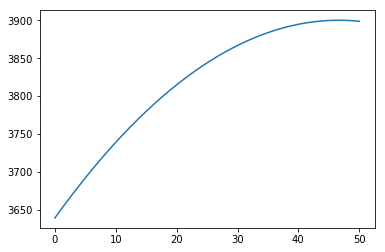

In [27]:

# create 1000 equally spaced points between -10 and 10
x = numpy.linspace(0, 50, 1000)

# calculate the y value for each element of the x vector
y = -0.12*x**2 + 11.2*x + 3639

fig, ax = plt.subplots()
ax.plot(x, y)


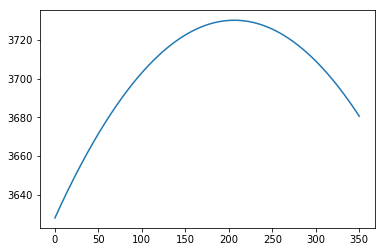

In [28]:
# create 1000 equally spaced points between -10 and 10
x = numpy.linspace(0, 350, 1000)

# calculate the y value for each element of the x vector
y = -0.0024*x**2 + 0.99*x + 3628

fig, ax = plt.subplots()
ax.plot(x, y)

In [174]:
ds = dm.groupby('seq')['rsosh', 'tsosh', 'griph', 'ptisoh'].mean()
dsds.iloc[3]/ds.iloc[0]-1

,rsosh,tsosh,griph,ptisoh
seq,,,,
1,3790.329834,3655.376953,21.935749,114.355705
2,3825.274170,3689.765381,22.835051,127.473358
3,3850.354736,3722.456543,25.640434,142.547119
4,3884.240234,3800.117676,30.413963,144.628601


In [175]:
ds.iloc[3]/ds.iloc[0]-1

rsosh     0.024776
tsosh     0.039597
griph     0.386502
ptisoh    0.264726
dtype: float32

In [176]:
d0 = dm[dm['gender']==0].groupby('seq')['rsosh', 'tsosh', 'griph', 'ptisoh'].mean()
d0

,rsosh,tsosh,griph,ptisoh
seq,,,,
1,3789.402832,3653.244141,22.269278,118.399994
2,3813.988281,3680.170410,24.090828,129.796768
3,3835.700928,3705.180664,27.410170,150.164444
4,3850.760254,3788.750000,34.442169,142.726242


In [177]:
d0.iloc[3]/d0.iloc[0]-1

rsosh     0.016192
tsosh     0.037092
griph     0.546623
ptisoh    0.205458
dtype: float32

In [178]:
d1 = dm[dm['gender']==1].groupby('seq')['rsosh', 'tsosh', 'griph', 'ptisoh'].mean()
d1

,rsosh,tsosh,griph,ptisoh
seq,,,,
1,3791.439941,3657.930908,21.536337,109.512550
2,3837.556152,3700.207031,21.468468,124.944931
3,3867.153320,3742.260498,23.611713,133.815048
4,3914.000000,3810.222168,26.833334,146.319580


In [179]:
d1.iloc[3]/d1.iloc[0]-1

rsosh     0.032326
tsosh     0.041633
griph     0.245956
ptisoh    0.336099
dtype: float32

In [220]:
%%stata --data dm

sort id seq
xtset id seq

count 

tab gender if seq==1


xtsum rsosh tsosh griph ptisoh matu




       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
  425

     gender |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |         97       54.49       54.49
          1 |         81       45.51      100.00
------------+-----------------------------------
      Total |        178      100.00

Variable         |      Mean   Std. Dev.       Min        Max |    Observations
-----------------+--------------------------------------------+----------------
rsosh    overall |   3818.19   92.44142       3542       4140 |     N =     425
         between |             79.76557   3591.667       4119 |     n =     178
         within  |             49.92315    3498.19    4014.19 | T-bar = 2.38764
                 |                                            |
tsosh    overall |  3686.546   105.2203       3381       4015 |     N =     425
         between |             91.85334       3465     392

In [181]:
%%stata --data dm
sort id seq
xtset id seq

sktest rsosh  griph tsosh ptisoh

*xtreg  rsosh  griph  matu, re
*xtsktest 

******************************************
*xtsktest  rsosh  griph    
*xtdescribe 



       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit

                    Skewness/Kurtosis tests for Normality
                                                          ------ joint ------
    Variable |        Obs  Pr(Skewness)  Pr(Kurtosis) adj chi2(2)   Prob>chi2
-------------+---------------------------------------------------------------
       rsosh |        425     0.1577        0.0135        7.74         0.0209
       griph |        425     0.0000        0.0000       67.93         0.0000
       tsosh |        425     0.9212        0.4660        0.55         0.7613
      ptisoh |        425     0.0000        0.0000           .         0.0000
. *xtsktest . *xtsktest  rsosh  griph    


In [183]:
%%stata --data dm --graph

histogram griphs


(bin=20, start=-2.1366043, width=.32773573)


In [19]:
dm.describe()

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,ptiso,pt60,godin,paq,ntxc,cint,calc,vitd,vitd2,mvh,matu,age,gender,griph,ptisoh,rsosh,tsosh,mvhh,ntxh,godinh,paqh,calch,cinth,vitdh,rsoshs,tsoshs,griphs,ptisohs,ntxhs,mvhhs,godinhs,cinths,vitdhs,lgriphs,lptisohs
count,425.000000,425.000000,425.000000,425.000000,425.000000,50.0,11.0,415.000000,415.000000,379.000000,310.000000,310.000000,422.000000,425.000000,385.000000,422.000000,421.000000,421.000000,421.000000,307.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,247.000000,247.000000
mean,326.197647,1.430588,4.197647,1.868235,2.736471,1.0,1.0,3815.551807,3687.079518,23.438074,124.041290,84.050201,72.606635,3.144819,540.346619,1598.184814,976.547974,4.703625,189.981476,106.180466,-0.893577,11.850613,0.468235,23.342438,125.786736,3818.190186,3686.545898,103.634758,537.885498,72.607536,3.144819,976.546631,1598.122314,4.703828,0.000003,-0.000001,-6.731819e-08,1.032212e-07,-1.234167e-07,-1.436121e-07,5.385455e-08,7.180606e-08,-3.590303e-08,-0.192437,-0.157278
std,197.549787,0.495742,1.833518,0.877686,0.827711,0.0,0.0,100.909471,109.038357,7.364498,53.311306,33.349968,39.683328,0.662686,265.354980,482.215729,455.661133,3.152561,127.345634,41.705219,1.942006,2.003003,0.499578,6.712725,46.683552,92.441414,105.220322,36.930027,255.216660,39.542690,0.662686,453.506714,480.562256,3.137687,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.846174,1.020451
min,100.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,3542.000000,3367.000000,9.000000,32.647167,28.224886,0.000000,1.250000,56.308327,469.496002,51.714001,0.000000,0.000000,13.570000,-5.300000,7.500000,0.000000,9.000000,32.647167,3542.000000,3381.000000,13.570000,56.308327,0.000000,1.250000,51.714001,469.496002,0.000000,-2.987732,-2.903868,-2.136604e+00,-1.995126e+00,-1.886935e+00,-2.438795e+00,-1.836181e+00,-2.348554e+00,-1.499139e+00,-2.136604,-1.995126
25%,138.000000,1.000000,3.000000,1.000000,2.000000,1.0,1.0,3746.500000,3619.000000,18.000000,84.335386,58.508888,44.000000,2.718600,369.744904,1263.682983,652.146973,2.649000,107.401001,78.139999,-2.290000,10.340000,0.000000,19.000000,92.666969,3767.000000,3623.699951,82.000000,380.352814,44.000000,2.718600,661.242004,1264.697021,2.651000,-0.553758,-0.597280,-6.468964e-01,-7.094526e-01,-6.172508e-01,-5.858311e-01,-7.234595e-01,-6.938233e-01,-6.542489e-01,-0.721382,-0.880033
50%,189.000000,1.000000,4.000000,2.000000,3.000000,1.0,1.0,3820.000000,3689.000000,22.250000,114.025639,76.993565,65.000000,3.197700,514.754761,1548.725037,915.741028,4.204000,173.792007,99.110001,-1.000000,11.850000,0.000000,22.654043,120.684532,3820.000000,3686.000000,98.931030,513.239929,65.000000,3.197700,920.513977,1549.993042,4.259000,0.019578,-0.005188,-1.025507e-01,-1.092934e-01,-9.656724e-02,-1.273686e-01,-1.923879e-01,-1.001520e-01,-1.417696e-01,-0.268903,-0.269717
75%,530.000000,2.000000,6.000000,2.000000,3.000000,1.0,1.0,3878.000000,3758.000000,27.500000,156.607567,102.830297,92.750000,3.663800,662.435608,1878.681793,1196.994019,6.464000,263.270996,133.389999,0.450000,13.230000,1.000000,26.486280,150.466110,3872.000000,3751.000000,119.959816,650.394531,92.000000,3.663800,1196.979004,1878.453003,6.427000,0.582096,0.612563,4.683408e-01,5.286525e-01,4.408374e-01,4.420538e-01,4.904184e-01,5.833390e-01,5.491853e-01,0.250948,0.324779
max,583.000000,2.000000,7.000000,4.000000,4.000000,1.0,1.0,4140.000000,4015.000000,53.000000,343.836792,237.822296,234.000000,4.610400,1754.324463,3624.724121,2518.876953,21.211000,848.426025,235.000000,4.950000,17.549999,1.000000,53.000000,343.836792,4140.000000,4015.000000,235.000000,1754.324463,234.000000,4.610400,2518.876953,3624.724121,21.211000,3.481230,3.121584,4.418110e+00,4.670811e

In [219]:
%%stata --data dm --openstata

xtset id seq


gsem ///
(rsoshs <-  griphs l.rsoshs  M1[id]) ///
(griphs <-   matu godinhs l.griphs M2[id]  )

************************************


gsem ///
(rsoshs <-  griphs l.rsoshs   M1[id]) ///
(griphs <-   matu godinhs l.griphs   ), cov(e.rsoshs*e.griphs)


gsem ///
(rsoshs <-  griphs l.rsoshs matu  M1[id]) ///
(griphs <-   matu godinhs l.griphs M2[id]   ), cov(e.rsoshs*e.griphs)



       panel variable:  id (unbalanced)
        time variable:  seq, 1 to 4
                delta:  1 unit
> (rsoshs <-  griphs l.rsoshs  M1[id]) ///
> (griphs <-   matu godinhs l.griphs M2[id]  )

Fitting fixed-effects model:

Iteration 0:   log likelihood = -481.13678  
Iteration 1:   log likelihood = -481.13678  

Refining starting values:

Grid node 0:   log likelihood = -505.38805

Fitting full model:

Iteration 0:   log likelihood = -505.38805  (not concave)
Iteration 1:   log likelihood = -489.51402  (not concave)
Iteration 2:   log likelihood = -480.54632  
Iteration 3:   log likelihood = -470.45923  
Iteration 4:   log likelihood = -468.72865  
Iteration 5:   log likelihood =  -468.5791  
Iteration 6:   log likelihood = -468.57875  
Iteration 7:   log likelihood = -468.57875  

Generalized structural equation model           Number of obs     =        247

Response       : rsoshs
Family         : Gaussian
Link           : identity

Response       : griphs
Family         : Gau

In [198]:
%%stata --data dm --openstata

gsem ///
(rsoshs <-  griphs  matu    M1[id]) ///
(tsoshs <-  ptisohs matu    M2[id]) ///
(griphs <-   matu  matu  ) ///
(ptisohs <-  matu  matu  ) 


> (rsoshs <-  griphs  matu    M1[id]) ///
> (tsoshs <-  ptisohs matu    M2[id]) ///
> (griphs <-   matu  matu  ) ///
> (ptisohs <-  matu  matu  ) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -2103.2684  
Iteration 1:   log likelihood = -2103.2684  

Refining starting values:

Grid node 0:   log likelihood = -2060.5642

Fitting full model:

Iteration 0:   log likelihood = -2060.5642  (not concave)
Iteration 1:   log likelihood = -1988.0285  
Iteration 2:   log likelihood = -1971.4105  
Iteration 3:   log likelihood = -1965.5867  
Iteration 4:   log likelihood = -1956.2035  
Iteration 5:   log likelihood = -1955.8441  
Iteration 6:   log likelihood = -1955.8389  
Iteration 7:   log likelihood = -1955.8389  

Generalized structural equation model           Number of obs     =        425

Response       : rsoshs
Family         : Gaussian
Link           : identity

Response       : tsoshs
Family         : Gaussian
Link           : identity

Response       : griphs
Family

In [28]:
%%stata --data dm --openstata

gsem ///
(rsoshs <-  griphs  matu    M1[id]) ///
(tsoshs <-  ptisohs matu    M2[id]) ///
(griphs <-   matu  lgriphs  ) ///
(ptisohs <-  matu  lptisohs  ) ///
, covstruct(e.rsoshs e.griphs, un)  covstruct(e.tsoshs e.ptisohs, un) 

gsem ///
(rsoshs <-  griphs  matu    M1[id]) ///
(tsoshs <-  ptisohs matu    M1[id]) ///
(griphs <-   matu  lgriphs M2[id] ) ///
(ptisohs <-  matu  lptisohs M3[id] ) ///
, covstruct(e.rsoshs e.griphs, un)  covstruct(e.tsoshs e.ptisohs, un) 


'Failed to open Stata'

In [10]:
%%stata --data dm --openstata


/*
gsem ///
(rsosh <-  griph  matu ntxh       M1[id]) ///
(tsosh <-  ptisoh matu ntxh mvhh  M2[id]) ///
(griph <-   matu godinh cinth vitdh) ///
(ptisoh <-  matu godinh cinth vitdh) , constraints(1)
matrix b = e(b)
*/

gsem ///
(rsoshs <-  griphs  matu ntxhs       M1[id]) ///
(tsoshs <-  ptisohs matu ntxhs  mvhhs M1[id]) ///
(griphs <-   matu godinhs   ) ///
(ptisohs <-  matu godinhs mvhhs   )
matrix b = e(b)


gsem ///
(rsoshs <-  griphs  matu ntxhs        M1[id]) ///
(tsoshs <-  ptisohs matu ntxhs  mvhhs M1[id]) ///
(griphs <-   matu godinhs   M2[id] ) ///
(ptisohs <-  matu godinhs mvhhs   M2[id] )
matrix b = e(b)



> gsem ///
> (rsosh <-  griph  matu ntxh       M1[id]) ///
> (tsosh <-  ptisoh matu ntxh mvhh  M2[id]) ///
> (griph <-   matu godinh cinth vitdh) ///
> (ptisoh <-  matu godinh cinth vitdh) , constraints(1)
> matrix b = e(b)
> */> (rsoshs <-  griphs  matu ntxhs       M1[id]) ///
> (tsoshs <-  ptisohs matu ntxhs  mvhhs M1[id]) ///
> (griphs <-   matu godinhs   ) ///
> (ptisohs <-  matu godinhs mvhhs   )

Fitting fixed-effects model:

Iteration 0:   log likelihood =  -2061.266  
Iteration 1:   log likelihood =  -2061.266  

Refining starting values:

Grid node 0:   log likelihood = -2035.1766

Fitting full model:

Iteration 0:   log likelihood = -2035.1766  (not concave)
Iteration 1:   log likelihood = -1997.1003  
Iteration 2:   log likelihood = -1976.0247  
Iteration 3:   log likelihood = -1949.5156  
Iteration 4:   log likelihood = -1940.1012  
Iteration 5:   log likelihood = -1935.3189  
Iteration 6:   log likelihood = -1935.1798  
Iteration 7:   log likelihood = -1935.1776  
Iterati

In [11]:
%%stata --data dm

ivregress 2sls rsoshs  (griphs = matu godinhs )
estat endogenous


ivregress 2sls rsoshs  (griphs = matu godinhs )
est store ivreg 

reg  rsoshs griphs matu godinhs
hausman ivreg .,constant sigmamore df(1) 


regress griphs matu godinhs
predict v, resid
regress rsoshs matu griphs  v
test v


Instrumental variables (2SLS) regression          Number of obs   =        425
                                                  Wald chi2(1)    =     100.61
                                                  Prob > chi2     =     0.0000
                                                  R-squared       =     0.0982
                                                  Root MSE        =     .94851

------------------------------------------------------------------------------
      rsoshs |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
      griphs |   .7517547   .0749476    10.03   0.000       .60486    .8986493
       _cons |   3.13e-06   .0460097     0.00   1.000    -.0901743    .0901806
------------------------------------------------------------------------------
Instrumented:  griphs
Instruments:   matu godinhs

  Tests of endogeneity
  Ho: variables are exogenous

  Durbin (score) chi2(1)

In [94]:
%%stata --data dm 

di "******************************************SEM******************************************"

sem (rsoshs <-   ntxhs griphs  ) (griphs <-  matu godinhs) , cov(e.rsoshs*e.griphs) 

di "************************************************************************************"

gsem (rsoshs <-   ntxhs griphs  ) (griphs <-  matu godinhs) , cov(e.rsoshs*e.griphs) 

di "**********************************************************************************"
di "**********************************************************************************"
di "**********************************************************************************"

gsem (rsoshs <-   ntxhs griphs M1[id] ) (griphs <-  matu godinhs) , cov(e.rsoshs*e.griphs) 

di "**********************************************************************************"
di "**********************************************************************************"
di "**********************************************************************************"

gsem (rsoshs <-   ntxhs griphs M1[id] ) (griphs <-  matu godinhs ) , covstruct(e.rsoshs e.griphs, un) 

di "**********************************************************************************"
di "**********************************************************************************"
di "**********************************************************************************"

gsem (rsoshs <-   ntxhs griphs M1[id] ) (griphs <-  matu godinhs M2[id] ) , ///
covstruct(e.rsoshs e.griphs, un) ///
covstruct(M1[id] M2[id], un) 

'Failed to open Stata'

In [17]:
%%stata --data dm 

gsem (rsoshs <-griphs ntxhs M1[id] ) (griphs <-  matu godinhs) , covstruct(e.rsoshs e.griphs, un) 

********************************************************************
********************************************************************
gsem (griphs <-  matu godinhs M1[id])
predict ghat
gsem (rsoshs <- griphs ntxhs ghat M1[id])  
test ghat


Fitting fixed-effects model:

Iteration 0:   log likelihood = -1039.6987  
Iteration 1:   log likelihood = -1036.1161  
Iteration 2:   log likelihood = -1029.5125  
Iteration 3:   log likelihood = -1029.1186  
Iteration 4:   log likelihood = -1029.1133  
Iteration 5:   log likelihood = -1029.1133  

Refining starting values:

Grid node 0:   log likelihood = -1020.4779

Fitting full model:

Iteration 0:   log likelihood = -1020.4779  (not concave)
Iteration 1:   log likelihood = -986.94044  
Iteration 2:   log likelihood = -981.84827  
Iteration 3:   log likelihood = -981.41686  
Iteration 4:   log likelihood = -981.41619  
Iteration 5:   log likelihood = -981.41619  

Generalized structural equation model           Number of obs     =        425

Response       : rsoshs
Family         : Gaussian
Link           : identity

Response       : griphs
Family         : Gaussian
Link           : identity

Log likelihood = -981.41619

 ( 1)  [rsoshs]M1[id] = 1
---------------------------------

In [17]:
%%stata

webuse hsng2, clear
ivregress 2sls rent pcturban (hsngval = faminc)
sem (rent <- pcturban hsngval) (hsngval <- faminc pcturban), cov(e.rent*e.hsngval) nolog


(1980 Census housing data)

Instrumental variables (2SLS) regression          Number of obs   =         50
                                                  Wald chi2(2)    =      51.44
                                                  Prob > chi2     =     0.0000
                                                  R-squared       =     0.2887
                                                  Root MSE        =     29.517

------------------------------------------------------------------------------
        rent |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
     hsngval |   .0031938   .0006206     5.15   0.000     .0019775    .0044101
    pcturban |  -.5064118   .4815558    -1.05   0.293    -1.450244    .4374202
       _cons |   113.8143   20.52667     5.54   0.000      73.5828    154.0459
------------------------------------------------------------------------------
Instrumented:  hsngval

In [322]:
%%stata --data dm --openstata 

gsem ///
(rsoshs <-  griphs  matu ntxhs       M1[id]) 


> (rsoshs <-  griphs  matu ntxhs       M1[id]) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -527.40929  
Iteration 1:   log likelihood = -527.40929  

Refining starting values:

Grid node 0:   log likelihood = -517.75534

Fitting full model:

Iteration 0:   log likelihood = -517.75534  (not concave)
Iteration 1:   log likelihood = -482.79777  
Iteration 2:   log likelihood =    -477.48  
Iteration 3:   log likelihood = -477.06993  
Iteration 4:   log likelihood = -477.06912  
Iteration 5:   log likelihood = -477.06912  

Generalized structural equation model           Number of obs     =        425
Response       : rsoshs
Family         : Gaussian
Link           : identity
Log likelihood = -477.06912

 ( 1)  [rsoshs]M1[id] = 1
------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% Conf. Interval]
-------------+----------------------------------------------------------------
rsoshs

In [324]:
%%stata --data dm --openstata 


set seed 12345

bayesmh rsoshs griphs  matu ntxhs, reffects(id) likelihood(normal({var_0})) noconstant  ///
prior({rsoshs:i.id},  normal({rsoshs:_cons},{var_id})) ///
prior({rsoshs:_cons}, normal(0, 100)) ///
prior({rsoshs:griphs}, normal(0, 100)) ///
prior({rsoshs:matu}, normal(0, 100)) ///
prior({rsoshs:ntxhs}, normal(0, 100)) ///
prior({var_0},        igamma(0.001, 0.001)) ///
prior({var_id},       igamma(0.001, 0.001)) ///
block({rsoshs:_cons}, gibbs)  ///
block({var_0}, gibbs) block({var_id}, gibbs) ///
mcmcsize(5000) dots



> prior({rsoshs:i.id},  normal({rsoshs:_cons},{var_id})) ///
> prior({rsoshs:_cons}, normal(0, 100)) ///
> prior({rsoshs:griphs}, normal(0, 100)) ///
> prior({rsoshs:matu}, normal(0, 100)) ///
> prior({rsoshs:ntxhs}, normal(0, 100)) ///
> prior({var_0},        igamma(0.001, 0.001)) ///
> prior({var_id},       igamma(0.001, 0.001)) ///
> block({rsoshs:_cons}, gibbs)  ///
> block({var_0}, gibbs) block({var_id}, gibbs) ///
> mcmcsize(5000) dots
  
Burn-in 2500 aaaaaaaaa1000aaaaaaaaa2000aaaaa done
Simulation 5000 .........1000.........2000.........3000.........4000.........5000 done

Model summary
------------------------------------------------------------------------------
Likelihood: 
  rsoshs ~ normal(xb_rsoshs,{var_0})

Priors: 
               {rsoshs:i.id} ~ normal({rsoshs:_cons},{var_id})             (1)
  {rsoshs:griphs matu ntxhs} ~ normal(0,100)                               (1)
                     {var_0} ~ igamma(0.001,0.001)
              {rsoshs:_cons} ~ normal(0,100)

Hype

In [341]:
%%stata --data dm --openstata 

gsem ///
(rsoshs <-  griphs  matu ntxhs       M1[id]) ///
(griphs <- matu)


set seed 12345

bayesmh ///
(rsoshs griphs, reffects(id) noconstant likelihood(normal({var_0})) ) ///
(griphs matu, reffects(id) noconstant likelihood(normal({var_1})) ), ///
prior({rsoshs:i.id},  normal({rsoshs:_cons},{var_id})) ///
prior({rsoshs:_cons}, normal(0, 100)) ///
prior({rsoshs:griphs}, normal(0, 100)) ///
///
prior({griphs:i.id},  normal({griphs:_cons},{var_id2})) ///
prior({griphs:_cons}, normal(0, 100)) ///
prior({griphs:matu}, normal(0, 100)) ///
///
prior({var_0},        igamma(0.001, 0.001)) ///
prior({var_1},        igamma(0.001, 0.001)) ///
prior({var_id},       igamma(0.001, 0.001)) ///
prior({var_id2},       igamma(0.001, 0.001)) ///
block({rsoshs:_cons}, gibbs) ///
block({var_0}, gibbs) ///
block({var_id}, gibbs)  ///
///
block({griphs:_cons}, gibbs) ///
block({var_1}, gibbs) ///
block({var_id2}, gibbs)   ///
mcmcsize(5000) dots
        


> (rsoshs <-  griphs  matu ntxhs       M1[id]) ///
> (griphs <- matu)

Fitting fixed-effects model:

Iteration 0:   log likelihood = -1041.2259  
Iteration 1:   log likelihood = -1041.2259  

Refining starting values:

Grid node 0:   log likelihood = -1031.7984

Fitting full model:

Iteration 0:   log likelihood = -1031.7984  (not concave)
Iteration 1:   log likelihood = -996.61688  
Iteration 2:   log likelihood = -991.28363  
Iteration 3:   log likelihood = -990.88709  
Iteration 4:   log likelihood = -990.88573  
Iteration 5:   log likelihood = -990.88573  

Generalized structural equation model           Number of obs     =        425

Response       : rsoshs
Family         : Gaussian
Link           : identity

Response       : griphs
Family         : Gaussian
Link           : identity

Log likelihood = -990.88573

 ( 1)  [rsoshs]M1[id] = 1
------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% 

In [332]:
%%stata --data dm --openstata 

gsem ///
(rsoshs <-  griphs  matu ntxhs       M1[id]) ///
(griphs <- matu)


set seed 12345

bayesmh ///
(rsoshs griphs  matu ntxhs, reffects(id) likelihood(normal({var_0})) noconstant ) ///
(griphs matu, likelihood(normal({var_1})) ), ///
prior({rsoshs:i.id},  normal({rsoshs:_cons},{var_id})) ///
prior({rsoshs:_cons}, normal(0, 100)) ///
prior({rsoshs:griphs}, normal(0, 100)) ///
prior({rsoshs:matu}, normal(0, 100)) ///
prior({rsoshs:ntxhs}, normal(0, 100)) ///
///
prior({griphs:_cons}, normal(0, 100)) ///
prior({griphs:matu}, normal(0, 100)) ///
///
prior({var_0},        igamma(0.001, 0.001)) ///
prior({var_1},        igamma(0.001, 0.001)) ///
prior({var_id},       igamma(0.001, 0.001)) ///
block({rsoshs:_cons}, gibbs)  ///
block({var_0}, gibbs) block({var_id}, gibbs)  block({var_1}, gibbs)  ///
mcmcsize(5000) dots



> (rsoshs <-  griphs  matu ntxhs       M1[id]) ///
> (griphs <- matu)

Fitting fixed-effects model:

Iteration 0:   log likelihood = -1041.2259  
Iteration 1:   log likelihood = -1041.2259  

Refining starting values:

Grid node 0:   log likelihood = -1031.7984

Fitting full model:

Iteration 0:   log likelihood = -1031.7984  (not concave)
Iteration 1:   log likelihood = -996.61688  
Iteration 2:   log likelihood = -991.28363  
Iteration 3:   log likelihood = -990.88709  
Iteration 4:   log likelihood = -990.88573  
Iteration 5:   log likelihood = -990.88573  

Generalized structural equation model           Number of obs     =        425

Response       : rsoshs
Family         : Gaussian
Link           : identity

Response       : griphs
Family         : Gaussian
Link           : identity

Log likelihood = -990.88573

 ( 1)  [rsoshs]M1[id] = 1
------------------------------------------------------------------------------
             |      Coef.   Std. Err.      z    P>|z|     [95% 

In [335]:
%%stata --data dm --openstata 



set seed 12345

bayesmh///
(rsoshs i.id griphs, likelihood(normal({var_0})) noconstant) ///
(griphs i.id matu, likelihood(normal({var_1})) noconstant) ///
///
prior ({rsoshs:i.id},                                 ///
mvnormal(2, {rsoshs:_cons}, {griphs:griphs}, {covar,m}))    ///
///
block ({rsoshs: i.id},        reffects)                           ///
block ({griphs: i.id#c.week}, reffects)                           ///
///
prior({var_0},   igamma(0.01, 0.01)) block({var_0}, gibbs)        ///
prior({covar,m}, iwishart(2, 3, I(2))) block({covar,m}, gibbs)    ///
///
prior({rsoshs:griphs _cons}, normal(0, 1e2))                        ///
block({rsoshs:_cons}) block({rsoshs:griphs})
        


. > ///
> prior ({rsoshs:i.id i.id#c.griphs},                                 ///
> mvnormal(2, {rsoshs:_cons}, {rsoshs:griphs}, {covar,m}))    ///
> ///
> block ({rsoshs: i.id},        reffects)                           ///
> block ({rsoshs: i.id#c.week}, reffects)                           ///
> ///
> prior({var_0},   igamma(0.01, 0.01)) block({var_0}, gibbs)        ///
> prior({covar,m}, iwishart(2, 3, I(2))) block({covar,m}, gibbs)    ///
> ///
> prior({rsoshs:griphs _cons}, normal(0, 1e2))                        ///
> block({rsoshs:_cons}) block({rsoshs:griphs})
id#c.week: maxvar too small
    You have attempted to use an interaction with too many levels or attempted to fit a model with too many variables.  You need to increase maxvar; it is currently 5000.  Use set maxvar; see help 
    maxvar.

    If you are using factor variables and included an interaction that has lots of missing cells, either increase maxvar or set emptycells drop to reduce the required matrix size; see h

In [274]:
dm.head(10)

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,ptiso,pt60,godin,paq,ntxc,cint,calc,vitd,vitd2,mvh,matu,age,gender,griph,ptisoh,rsosh,tsosh,mvhh,ntxh,godinh,paqh,calch,cinth,rsoshs,tsoshs,griphs,ptisohs,ntxhs,mvhhs,godinhs,cinths
0,100,1,1,1,4.0,NaN,NaN,3828.0,3601.0,NaN,113.928055,69.291710,37.0,2.5866,711.848145,1572.000000,1077.668945,3.382,135.274002,105.709999,-1.67,11.75,0,23.770721,113.928055,3828.000000,3601.0,105.709999,711.848145,37.0,2.5866,1077.668945,1572.000000,0.106119,-0.813017,0.063802,-0.254023,0.681627,0.056194,-0.897923,-0.054358
1,100,1,3,2,4.0,NaN,NaN,3898.0,3629.0,27.0,136.023758,87.778656,48.0,3.1656,760.093933,2219.011963,1212.817993,1.025,41.018002,93.620003,-0.71,12.71,0,27.000000,136.023758,3898.000000,3629.0,93.620003,760.093933,48.0,3.1656,1212.817993,2219.011963,0.863356,-0.546909,0.544870,0.219285,0.870666,-0.271182,-0.619845,1.292007
2,100,1,5,3,4.0,1.0,NaN,3851.0,3677.0,37.0,177.053085,103.303604,44.0,3.2084,543.734619,2599.831055,874.338013,4.546,181.848007,98.139999,0.41,13.83,0,24.354441,177.053085,3822.112549,3677.0,98.139999,543.734619,44.0,3.2084,874.338013,2599.831055,0.042431,-0.090723,0.150759,1.098167,0.022918,-0.148788,-0.720964,2.084451
3,100,1,7,4,4.0,NaN,NaN,3952.0,3740.0,40.5,NaN,NaN,66.0,2.7597,454.364349,2482.117920,1672.296997,5.907,236.738998,88.139999,1.17,14.74,0,40.500000,134.567993,3952.000000,3740.0,88.139999,454.364349,66.0,2.7597,1672.296997,2482.117920,1.447509,0.508021,2.555976,0.188102,-0.327256,-0.419571,-0.164810,1.839503
4,101,1,1,1,1.0,NaN,NaN,3682.0,3603.0,NaN,133.048798,86.341110,25.0,1.7136,937.996765,1549.993042,1521.052002,7.432,297.299988,89.290001,-1.63,11.45,0,20.065380,133.048798,3682.000000,3603.0,89.290001,937.996765,25.0,1.7136,1521.052002,1549.993042,-1.473259,-0.794009,-0.488186,0.155559,1.567732,-0.388431,-1.201280,-0.100152
5,102,1,1,1,4.0,NaN,NaN,3935.0,3916.0,NaN,171.360291,83.164680,45.0,2.9459,435.431000,1308.953979,504.941986,3.238,129.501999,86.570000,-1.24,12.29,0,26.486280,171.360291,3935.000000,3916.0,86.570000,435.431000,45.0,2.9459,504.941986,1308.953979,1.263609,2.180701,0.468341,0.976223,-0.401441,-0.462084,-0.695685,-0.601729
6,102,1,3,2,4.0,NaN,NaN,3899.0,3863.0,27.0,NaN,NaN,102.0,3.8297,650.394531,1260.655029,771.072998,1.084,43.356998,68.709999,-0.27,13.26,0,27.000000,155.151871,3899.000000,3863.0,68.709999,650.394531,102.0,3.8297,771.072998,1260.655029,0.874173,1.676996,0.544870,0.629025,0.440837,-0.945701,0.745262,-0.702234
7,102,1,5,3,4.0,NaN,NaN,3878.0,3908.0,42.0,210.997086,134.422821,113.0,3.3557,906.064087,2509.722900,552.890015,1.895,89.841003,59.139999,0.77,14.30,0,42.000000,210.997086,3878.000000,3908.0,59.139999,906.064087,113.0,3.3557,552.890015,2509.722900,0.647002,2.104671,2.779432,1.825276,1.442612,-1.204840,1.023339,1.896946
8,102,1,7,4,4.0,NaN,NaN,3951.0,4015.0,42.0,NaN,NaN,123.0,2.4667,NaN,1685.947021,534.088013,3.337,135.897003,60.709999,2.08,15.38,0,42.000000,180.588852,3951.000000,4015.0,60.709999,402.240692,123.0,2.4667,534.088013,1685.947021,1.436692,3.121584,2.779432,1.173906,-0.531489,-1.162327,1.276137,0.182754
9,103,1,1,1,3.0,NaN,NaN,3768.0,3686.0,NaN,146.600281,90.861717,33.0,3.2554,737.074768,2551.882080,994.062988,3.764,150.544006,120.570000,-1.91,11.83,0,22.247978,146.600281,3768.000000,3686.0,120.570000,737.074768,33.0,3.2554,994.062988,2551.882080,-0.542940,-0.005188,-0.163043,0.445843,0.780471,0.458576,-0.999042,1.984675


In [275]:
dm.describe()

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,ptiso,pt60,godin,paq,ntxc,cint,calc,vitd,vitd2,mvh,matu,age,gender,griph,ptisoh,rsosh,tsosh,mvhh,ntxh,godinh,paqh,calch,cinth,rsoshs,tsoshs,griphs,ptisohs,ntxhs,mvhhs,godinhs,cinths
count,425.000000,425.000000,425.000000,425.000000,425.000000,50.0,11.0,415.000000,415.000000,379.000000,310.000000,310.000000,422.000000,425.000000,385.000000,422.000000,421.000000,421.000000,421.000000,307.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,425.000000,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02,4.250000e+02
mean,326.197647,1.430588,4.197647,1.868235,2.736471,1.0,1.0,3815.551807,3687.079518,23.438074,124.041290,84.050201,72.606635,3.144819,540.346619,1598.184814,976.547974,4.703625,189.981476,106.180466,-0.893577,11.850613,0.468235,23.342438,125.786736,3818.190186,3686.545898,103.634758,537.885498,72.519432,3.144819,976.546631,1598.122314,0.000003,-0.000001,-6.731819e-08,1.032212e-07,-1.234167e-07,-1.436121e-07,2.692727e-08,7.180606e-08
std,197.549787,0.495742,1.833518,0.877686,0.827711,0.0,0.0,100.909471,109.038357,7.364498,53.311306,33.349968,39.683328,0.662686,265.354980,482.215729,455.661133,3.152561,127.345634,41.705219,1.942006,2.003003,0.499578,6.712725,46.683552,92.441414,105.220322,36.930027,255.216660,39.557331,0.662686,453.506714,480.562256,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,100.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,3542.000000,3367.000000,9.000000,32.647167,28.224886,0.000000,1.250000,56.308327,469.496002,51.714001,0.000000,0.000000,13.570000,-5.300000,7.500000,0.000000,9.000000,32.647167,3542.000000,3381.000000,13.570000,56.308327,0.000000,1.250000,51.714001,469.496002,-2.987732,-2.903868,-2.136604e+00,-1.995126e+00,-1.886935e+00,-2.438795e+00,-1.833274e+00,-2.348554e+00
25%,138.000000,1.000000,3.000000,1.000000,2.000000,1.0,1.0,3746.500000,3619.000000,18.000000,84.335386,58.508888,44.000000,2.718600,369.744904,1263.682983,652.146973,2.649000,107.401001,78.139999,-2.290000,10.340000,0.000000,19.000000,92.666969,3767.000000,3623.699951,82.000000,380.352814,44.000000,2.718600,661.242004,1264.697021,-0.553758,-0.597280,-6.468964e-01,-7.094526e-01,-6.172508e-01,-5.858311e-01,-7.209645e-01,-6.938233e-01
50%,189.000000,1.000000,4.000000,2.000000,3.000000,1.0,1.0,3820.000000,3689.000000,22.250000,114.025639,76.993565,65.000000,3.197700,514.754761,1548.725037,915.741028,4.204000,173.792007,99.110001,-1.000000,11.850000,0.000000,22.654043,120.684532,3820.000000,3686.000000,98.931030,513.239929,65.000000,3.197700,920.513977,1549.993042,0.019578,-0.005188,-1.025507e-01,-1.092934e-01,-9.656724e-02,-1.273686e-01,-1.900895e-01,-1.001520e-01
75%,530.000000,2.000000,6.000000,2.000000,3.000000,1.0,1.0,3878.000000,3758.000000,27.500000,156.607567,102.830297,92.750000,3.663800,662.435608,1878.681793,1196.994019,6.464000,263.270996,133.389999,0.450000,13.230000,1.000000,26.486280,150.466110,3872.000000,3751.000000,119.959816,650.394531,92.000000,3.663800,1196.979004,1878.453003,0.582096,0.612563,4.683408e-01,5.286525e-01,4.408374e-01,4.420538e-01,4.924642e-01,5.833390e-01
max,583.000000,2.000000,7.000000,4.000000,4.000000,1.0,1.0,4140.000000,4015.000000,53.000000,343.836792,237.822296,234.000000,4.610400,1754.324463,3624.724121,2518.876953,21.211000,848.426025,235.000000,4.950000,17.549999,1.000000,53.000000,343.836792,4140.000000,4015.000000,235.000000,1754.324463,234.000000,4.610400,2518.876953,3624.724121,3.481230,3.121584,4.418110e+00,4.670811e+00,4.766299e+00,3.557139e+00,4.082191e+00,4.217147e+00


In [267]:
dm.columns

Index(['id', 'session', 'sequence', 'seq', 'trips', 'nota', 'falk', 'rsos',
       'tsos', 'grip', 'ptiso', 'pt60', 'godin', 'paq', 'ntxc', 'cint', 'calc',
       'vitd', 'vitd2', 'mvh', 'matu', 'age', 'gender', 'griph', 'ptisoh',
       'rsosh', 'tsosh', 'mvhh', 'ntxh', 'godinh', 'paqh', 'calch', 'cinth',
       'rsoshs', 'tsoshs', 'griphs', 'ptisohs', 'ntxhs', 'mvhhs', 'godinhs'],
      dtype='object')

In [272]:
%%stata --data dm --openstata 

constraint 1 M1[id]=M2[id]

gsem ///
(rsosh <-  griph  matu ntxh       M1[id]) ///
(tsosh <-  ptisoh matu ntxh mvhh  M2[id]) ///
(griph <-   matu godinh cinth) ///
(ptisoh <-  matu godinh cinth) , constraints(1)
matrix b = e(b)







> (rsosh <-  griph  matu ntxh mvhh  M1[id]) ///
> (tsosh <-  ptisoh matu ntxh mvhh  M2[id]) ///
> (griph <-   matu godinh cinth) ///
> (ptisoh <-  matu godinh cinth) ,constraints(1)
(note: constraint number 1 caused error r(111))

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8396.1149  
Iteration 1:   log likelihood = -8396.1149  

Refining starting values:

Grid node 0:   log likelihood =   -8353.93

Fitting full model:

Iteration 0:   log likelihood =   -8353.93  (not concave)
Iteration 1:   log likelihood = -8314.3246  (not concave)
Iteration 2:   log likelihood = -8272.3864  (not concave)
Iteration 3:   log likelihood = -8258.4659  (not concave)
Iteration 4:   log likelihood = -8251.2939  (not concave)
Iteration 5:   log likelihood = -8249.0693  
Iteration 6:   log likelihood = -8247.9025  (not concave)
Iteration 7:   log likelihood = -8247.6797  
Iteration 8:   log likelihood = -8247.5023  (not concave)
Iteration 9:   log likelihood = -8247.3273  
Iteration 10: 

In [230]:
%%stata --graph -d dm

graph twoway (scatter tsosh mvhh) 

In [98]:
%%stata --data dm --openstata 

drop if trips==1

gsem ///
(rsosh <-  griph  matu ntxh M1[id]) ///
(tsosh <-  ptisoh matu mvhh M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) 
matrix b = e(b)

gsem ///
(rsosh <-  griph  matu  ntxh M1[id]) ///
(tsosh <-  ptisoh matu  mvhh M2[id]) ///
(griph <-   matu M3[id]) ///
(ptisoh <-  matu M4[id]) , from(b, skip)

gsem ///
(rsoshs <-  griphs  matu ntxhs M1[id]) ///
(tsoshs <-  ptisohs matu mvhhs M2[id]) ///
(griphs <-   matu   ) ///
(ptisohs <-  matu   ) 
matrix b = e(b)

gsem ///
(rsoshs <-  griphs  matu ntxhs M1[id]) ///
(tsoshs <-  ptisohs matu mvhhs M2[id]) ///
(griph <-   matu M3[id]) ///
(ptisoh <-  matu M4[id]) , from(b, skip)

'Failed to open Stata'

In [87]:
%%stata --data dm --openstata 

keep id seq trips rsosh tsosh griph ptisoh ntxh mvhh matu
drop if missing(rsosh)
drop if missing(tsosh)
drop if missing(griph)
drop if missing(ptisoh)
drop if missing(ntxh)
drop if missing(mvhh)
drop if missing(matu)

drop if trips==1
count

gsem ///
(rsosh <-  griph  matu ntxh M1[id]) ///
(tsosh <-  ptisoh matu mvhh M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) 
matrix b = e(b)

gsem ///
(rsosh <-  griph  matu  ntxh M1[id]) ///
(tsosh <-  ptisoh matu  mvhh M2[id]) ///
(griph <-   matu M3[id]) ///
(ptisoh <-  matu M4[id]) , from(b, skip)


. keep id rsosh tsosh griph ptisoh ntxh mvhh matu
(0 observations deleted)
(10 observations deleted)
(0 observations deleted)
(0 observations deleted)
(0 observations deleted)
(0 observations deleted)
(0 observations deleted)
  415
> (rsosh <-  griph  matu ntxh M1[id]) ///
> (tsosh <-  ptisoh matu mvhh M2[id]) ///
> (griph <-   matu   ) ///
> (ptisoh <-  matu   ) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8172.5731  
Iteration 1:   log likelihood = -8172.5731  

Refining starting values:

Grid node 0:   log likelihood = -8142.0646

Fitting full model:

Iteration 0:   log likelihood = -8142.0646  (not concave)
Iteration 1:   log likelihood = -8086.9295  (not concave)
Iteration 2:   log likelihood = -8073.0673  (not concave)
Iteration 3:   log likelihood = -8054.6206  (not concave)
Iteration 4:   log likelihood = -8043.7581  
Iteration 5:   log likelihood = -8037.2353  (not concave)
Iteration 6:   log likelihood = -8035.9737  
Iteration 7:   log likelihood = -8035.

In [53]:
dm.describe()

,id,session,sequence,seq,trips,nota,falk,rsos,tsos,grip,...,mvh,matu,age,gender,griph,ptisoh,rsosh,tsosh,mvhh,ntxch
count,425.000000,425.000000,425.000000,425.000000,425.000000,50.0,11.0,415.000000,415.000000,379.000000,...,307.000000,425.000000,425.000000,425.000000,425.000000,415.000000,425.000000,415.000000,420.000000,420.000000
mean,326.197647,1.430588,4.197647,1.868235,2.736471,1.0,1.0,3815.551807,3687.079518,23.438074,...,106.180466,-0.893577,11.850613,0.468235,23.412334,131.787201,3815.268311,3687.079590,104.799309,538.985962
std,197.549787,0.495742,1.833518,0.877686,0.827711,0.0,0.0,100.909471,109.038357,7.364498,...,41.705219,1.942006,2.003003,0.499578,6.997608,34.685455,60.782661,71.749718,36.542171,255.051041
min,100.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.0,3542.000000,3367.000000,9.000000,...,13.570000,-5.300000,7.500000,0.000000,9.000000,72.146973,3554.000000,3367.000000,13.570000,56.308327
25%,138.000000,1.000000,3.000000,1.000000,2.000000,1.0,1.0,3746.500000,3619.000000,18.000000,...,78.139999,-2.290000,10.340000,0.000000,18.500000,114.988209,3780.298096,3646.712646,83.287502,384.042091
50%,189.000000,1.000000,4.000000,2.000000,3.000000,1.0,1.0,3820.000000,3689.000000,22.250000,...,99.110001,-1.000000,11.850000,0.000000,22.500000,126.535263,3814.430908,3676.513672,102.535000,521.473938
75%,530.000000,2.000000,6.000000,2.000000,3.000000,1.0,1.0,3878.000000,3758.000000,27.500000,...,133.389999,0.450000,13.230000,1.000000,27.000000,138.835381,3853.525146,3713.966064,118.456932,648.279327
max,583.000000,2.000000,7.000000,4.000000,4.000000,1.0,1.0,4140.000000,4015.000000,53.000000,...,235.000000,4.950000,17.549999,1.000000,53.000000,343.836792,3971.000000,4016.659912,235.000000,1754.324463


In [ ]:
%%stata --data dm --openstata

*sum rsosh tsosh griph ptisoh ntxh

tab trips
drop if trips==1

constraint 1 M1[id]=M2[id]

gsem ///
(rsos <-  griph  matu  M1[id]) ///
(tsos <-  ptisoh matu  M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) ,  constraints(1)
matrix b = e(b)


gsem ///
(rsos <-  griph  matu ntxh M1[id]) ///
(tsos <-  ptisoh matu mvhh M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) , from(b, skip)  constraints(1)
matrix b = e(b)



gsem ///
(rsos <-  griph  matu  ntxh M1[id]) ///
(tsos <-  ptisoh matu  mvhh M2[id]) ///
(griph <-   matu   M3[id]) ///
(ptisoh <-  matu   M4[id]) , from(b, skip) constraints(1)


In [61]:
%%stata --data dm --openstata

*sum rsosh tsosh griph ptisoh ntxh

tab trips
drop if trips==1

constraint 1 M1[id]=M2[id]

gsem ///
(rsos <-  griph  matu  M1[id]) ///
(tsos <-  ptisoh matu  M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) ,  constraints(1)
matrix b = e(b)


gsem ///
(rsos <-  griph  matu ntxh M1[id]) ///
(tsos <-  ptisoh matu mvhh M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) , from(b, skip)  constraints(1)
matrix b = e(b)



gsem ///
(rsos <-  griph  matu  ntxh M1[id]) ///
(tsos <-  ptisoh matu  mvhh M2[id]) ///
(griph <-   matu   M3[id]) ///
(ptisoh <-  matu   M4[id]) , from(b, skip) constraints(1)


'Failed to open Stata'

In [55]:
%%stata --data dm --openstata

*sum rsosh tsosh griph ptisoh ntxh

tab trips
drop if trips==1

gsem ///
(rsos <-  griph  matu  M1[id]) ///
(tsos <-  ptisoh matu  M1[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) 
matrix b = e(b)


gsem ///
(rsos <-  griph  matu  		M1[id]) ///
(tsos <-  ptisoh matu mvhh  M2[id]) ///
(griph <-   matu   ) ///
(ptisoh <-  matu   ) , from(b, skip)
matrix b = e(b)


gsem ///
(rsos <-  griph  matu  ntxh M1[id]) ///
(tsos <-  ptisoh matu  mvhh M2[id]) ///
(griph <-   matu   M3[id]) ///
(ptisoh <-  matu   M4[id]) , from(b, skip)



. gsem ///
> (rsos <-  griph  matu  M1[id]) ///
> (tsos <-  ptisoh matu  M1[id]) ///
> (griph <-   matu   ) ///
> (ptisoh <-  matu   ) 

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8225.7985  
Iteration 1:   log likelihood = -8225.7985  

Refining starting values:

Grid node 0:   log likelihood = -8225.7739

Fitting full model:

Iteration 0:   log likelihood = -8225.7739  (not concave)
Iteration 1:   log likelihood =  -8190.627  (not concave)
Iteration 2:   log likelihood = -8152.3166  (not concave)
Iteration 3:   log likelihood = -8141.4184  
Iteration 4:   log likelihood = -8130.7432  
Iteration 5:   log likelihood = -8130.5141  (not concave)
Iteration 6:   log likelihood = -8126.7435  (not concave)
Iteration 7:   log likelihood = -8124.8415  
Iteration 8:   log likelihood = -8121.9066  
Iteration 9:   log likelihood =  -8115.588  
Iteration 10:  log likelihood = -8111.1424  (not concave)
Iteration 11:  log likelihood = -8109.8758  
Iteration 12:  log likelihood =

In [25]:
%%stata -d dm -gr

histogram ptisoh


(bin=20, start=32.647167, width=15.559481)
